In [1]:
# Cell 1: Setup, Configuration, and Imports for Custom U-Net with Transformer

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2 # OpenCV for image loading and processing
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms # Using v2 for up-to-date transforms

# Optimized Configuration for Custom U-Net with Transformer Bottleneck
CONFIG = {
    "DATASET_PATH": r"C:\college\_cutie\cv\square_dataset\square_dataset", # Fixed path to correct dataset
    "IMAGE_DIR_NAME": "preprocessed_images", 
    "MASK_DIR_NAME": "masks",
    "CSV_NAME": "dataset.csv",
    "IMAGE_SIZE": (256, 256), # Optimal size for U-Net + Transformer
    "BATCH_SIZE": 4, # Reduced for Transformer memory requirements
    "NUM_CLASSES_SEG": 3, 
    "LEARNING_RATE": 1e-4, # Conservative learning rate for Transformers
    "NUM_EPOCHS": 50, # More epochs for better quality
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "CHECKPOINT_DIR": "checkpoints_custom_unet_transformer", # Dedicated directory
    "MULTITASK": True, 
    "NUM_REGRESSION_TARGETS": 2, 
    "PIN_MEMORY": True, # Enable for GPU speed optimization
    "NUM_WORKERS": 2, # Moderate workers for stability
    "SEED": 42, 
    "RESUME_TRAINING": False, 
    "LATEST_CHECKPOINT_PATH": None, 
    "VALIDATION_SPLIT": 0.2, 
    "TEST_SPLIT": 0.1,
    "SAVE_EVERY_EPOCH": True,  # New flag for every-epoch saving
    "MODEL_NAME": "Custom_UNet_Transformer_v1.0",  # Model version for tracking
    # Transformer-specific parameters
    "PATCH_SIZE": 16,  # Patch size for Transformer (not used in bottleneck approach)
    "EMBED_DIM": 512,  # Embedding dimension for transformer bottleneck
    "NUM_HEADS": 8,    # Number of attention heads
    "NUM_LAYERS": 6,   # Number of Transformer layers
    "MLP_RATIO": 4.0,  # MLP expansion ratio
    "DROPOUT": 0.1,    # Dropout rate
    "ATTENTION_DROPOUT": 0.1,  # Attention dropout
}

# Create checkpoint directory if it doesn't exist
os.makedirs(CONFIG["CHECKPOINT_DIR"], exist_ok=True)

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Optimized for Custom U-Net + Transformer training
    torch.backends.cudnn.deterministic = False  # Allow optimization
    torch.backends.cudnn.benchmark = True      # Optimize for consistent input sizes

set_seed(CONFIG["SEED"])

print(f"🚀 {CONFIG['MODEL_NAME']} Training Setup")
print(f"=" * 60)
print(f"Using device: {CONFIG['DEVICE']}")
print(f"PyTorch Version: {torch.__version__}")
if CONFIG["DEVICE"].type == 'cuda':
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"cuDNN Version: {torch.backends.cudnn.version()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"GPU Memory Available: {torch.cuda.memory_reserved(0) / 1024**3:.1f} GB")
print(f"Number of DataLoader workers: {CONFIG['NUM_WORKERS']}")
print(f"Image size: {CONFIG['IMAGE_SIZE']}")
print(f"Batch size: {CONFIG['BATCH_SIZE']}")
print(f"Learning rate: {CONFIG['LEARNING_RATE']}")
print(f"Total epochs: {CONFIG['NUM_EPOCHS']}")
print(f"Checkpoint directory: {CONFIG['CHECKPOINT_DIR']}")
print(f"Save every epoch: {CONFIG['SAVE_EVERY_EPOCH']}")
print(f"Transformer config: Embed={CONFIG['EMBED_DIM']}, Heads={CONFIG['NUM_HEADS']}, Layers={CONFIG['NUM_LAYERS']}")
print(f"=" * 60)

# Enhanced image transformations for NIR data
data_transforms = {
    'image': transforms.Compose([
        transforms.ToImage(), 
        transforms.Resize(CONFIG["IMAGE_SIZE"], antialias=True),
        transforms.ToDtype(torch.float32, scale=True), 
        # Enhanced normalization for NIR images
        transforms.Normalize(mean=[0.485], std=[0.229])  # ImageNet-style normalization adapted for grayscale
    ]),
    'mask': transforms.Compose([
        transforms.ToImage(),
        transforms.Resize(CONFIG["IMAGE_SIZE"], interpolation=transforms.InterpolationMode.NEAREST, antialias=False), 
        transforms.ToDtype(torch.long, scale=False) 
    ])
}

# Data augmentations for training (optional)
train_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5))
])

print("✅ Configuration and transforms initialized for Custom U-Net + Transformer training!")


🚀 Custom_UNet_Transformer_v1.0 Training Setup
Using device: cuda
PyTorch Version: 2.7.1+cu118
CUDA Version: 11.8
cuDNN Version: 90100
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
GPU Memory: 6.0 GB
GPU Memory Available: 0.0 GB
Number of DataLoader workers: 2
Image size: (256, 256)
Batch size: 4
Learning rate: 0.0001
Total epochs: 50
Checkpoint directory: checkpoints_custom_unet_transformer
Save every epoch: True
Transformer config: Embed=512, Heads=8, Layers=6
✅ Configuration and transforms initialized for Custom U-Net + Transformer training!


In [2]:
# Cell 2: Custom Dataset Class

class NIRDataset(Dataset):
    def __init__(self, dataframe, base_path, image_dir, mask_dir, image_transform=None, mask_transform=None, multitask=False, image_size_for_coords=512):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with image and mask paths and regression targets.
            base_path (str): Base directory of the dataset.
            image_dir (str): Directory name for images within base_path.
            mask_dir (str): Directory name for masks within base_path.
            image_transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
            multitask (bool): If True, also loads regression targets.
            image_size_for_coords (int): The image size used for normalizing coordinates.
        """
        self.dataframe = dataframe
        self.base_path = base_path
        self.image_dir = image_dir 
        self.mask_dir = mask_dir   
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.multitask = multitask
        self.image_size_for_coords = image_size_for_coords

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_rel_path = self.dataframe.iloc[idx]['preprocessed_image']
        mask_rel_path = self.dataframe.iloc[idx]['mask']
        
        img_name = os.path.join(self.base_path, img_rel_path)
        mask_name = os.path.join(self.base_path, mask_rel_path)

        try:
            image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
            if image is None:
                raise FileNotFoundError(f"Image not found or corrupted: {img_name} (relative: {img_rel_path})")
            
            mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise FileNotFoundError(f"Mask not found or corrupted: {mask_name} (relative: {mask_rel_path})")
            
            mask[mask > CONFIG["NUM_CLASSES_SEG"] - 1] = 0 

        except Exception as e:
            print(f"Error loading data at index {idx} (Image: {img_name}, Mask: {mask_name}): {e}")
            dummy_image = torch.zeros((1, *CONFIG["IMAGE_SIZE"]), dtype=torch.float32) 
            dummy_mask = torch.zeros(CONFIG["IMAGE_SIZE"], dtype=torch.long) 
            if self.multitask:
                dummy_coords = torch.zeros(CONFIG["NUM_REGRESSION_TARGETS"], dtype=torch.float32)
                return dummy_image, dummy_mask, dummy_coords
            return dummy_image, dummy_mask

        if image.ndim == 2:
            image = image[:, :, np.newaxis] 
        if mask.ndim == 2:
            mask = mask[:, :, np.newaxis]   

        if self.image_transform:
            image = self.image_transform(image) 

        if self.mask_transform:
            mask = self.mask_transform(mask) 
            mask = mask.squeeze(0) 

        if self.multitask:
            acf_x_val = self.dataframe.iloc[idx]['acf_center_x']
            acf_y_val = self.dataframe.iloc[idx]['acf_center_y']

            # --- Robust handling for acf_center_x and acf_center_y ---
            # Ensure they are scalars before creating the tensor.
            # This handles cases where CSV might interpret numbers as lists/arrays.
            try:
                if isinstance(acf_x_val, (list, tuple, np.ndarray)):
                    if len(acf_x_val) > 0:
                        acf_x = float(acf_x_val[0]) # Take the first element if it's iterable
                    else: # Handle empty iterable case
                        print(f"Warning: Empty list/array for acf_center_x at index {idx}. Using 0.")
                        acf_x = 0.0
                else:
                    acf_x = float(acf_x_val)

                if isinstance(acf_y_val, (list, tuple, np.ndarray)):
                    if len(acf_y_val) > 0:
                        acf_y = float(acf_y_val[0]) # Take the first element
                    else: # Handle empty iterable case
                        print(f"Warning: Empty list/array for acf_center_y at index {idx}. Using 0.")
                        acf_y = 0.0
                else:
                    acf_y = float(acf_y_val)
            except Exception as coord_err:
                print(f"Error processing coordinates at index {idx} (X: {acf_x_val}, Y: {acf_y_val}): {coord_err}. Using (0,0).")
                acf_x, acf_y = 0.0, 0.0
            # -----------------------------------------------------------

            # Now acf_x and acf_y are Python floats
            coords_list = [acf_x / self.image_size_for_coords, 
                           acf_y / self.image_size_for_coords]
            coords = torch.tensor(coords_list, dtype=torch.float32) # This will be 1D, shape [2]
            
            return image, mask, coords
        else:
            return image, mask


In [3]:
# Cell 3: Data Loading and Splitting with Robust Error Handling (Fixed for Windows)

from sklearn.model_selection import train_test_split
import threading
import queue
import time

# Load the dataset CSV
csv_path = os.path.join(CONFIG["DATASET_PATH"], CONFIG["CSV_NAME"])
print(f"Looking for CSV at: {csv_path}")
print(f"CSV exists: {os.path.exists(csv_path)}")

try:
    full_df = pd.read_csv(csv_path)
    print(f"Successfully loaded dataset with {len(full_df)} samples.")
    print(f"Dataset columns: {list(full_df.columns)}")
except FileNotFoundError:
    print(f"Error: {CONFIG['CSV_NAME']} not found at {csv_path}. Please check the path and file name.")
    if not os.path.exists(CONFIG["DATASET_PATH"]):
        print(f"Dataset path {CONFIG['DATASET_PATH']} does not exist.")
    full_df = pd.DataFrame()

if full_df.empty:
    print("DataFrame is empty. Cannot proceed with data loading.")
else:
    print(f"Loaded dataset with {len(full_df)} samples.")
    
    # Check for necessary columns
    required_cols = ['preprocessed_image', 'mask']
    if CONFIG["MULTITASK"]:
        required_cols.extend(['acf_center_x', 'acf_center_y'])
    
    missing_cols = [col for col in required_cols if col not in full_df.columns]
    if missing_cols:
        print(f"Error: Missing required columns in CSV: {missing_cols}")
        print(f"Available columns: {list(full_df.columns)}")
    else:
        print("✓ All required columns found!")

    # Split data: train, validation, test
    if len(full_df) > 1:
        train_val_df, test_df = train_test_split(
            full_df, 
            test_size=CONFIG["TEST_SPLIT"], 
            random_state=CONFIG["SEED"]
        )

        val_split_adjusted = CONFIG["VALIDATION_SPLIT"] / (1 - CONFIG["TEST_SPLIT"])
        if len(train_val_df) > 1 and val_split_adjusted < 1.0:
            train_df, val_df = train_test_split(
                train_val_df, 
                test_size=val_split_adjusted, 
                random_state=CONFIG["SEED"]
            )
        else:
            train_df = train_val_df
            val_df = pd.DataFrame(columns=full_df.columns)
    else:
        train_df = full_df
        val_df = pd.DataFrame(columns=full_df.columns)
        test_df = pd.DataFrame(columns=full_df.columns)

    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")

    # Create Datasets
    train_dataset = NIRDataset(
        train_df, CONFIG["DATASET_PATH"], CONFIG["IMAGE_DIR_NAME"], CONFIG["MASK_DIR_NAME"],
        image_transform=data_transforms['image'], mask_transform=data_transforms['mask'],
        multitask=CONFIG["MULTITASK"], image_size_for_coords=CONFIG["IMAGE_SIZE"][0]
    )
    val_dataset = NIRDataset(
        val_df, CONFIG["DATASET_PATH"], CONFIG["IMAGE_DIR_NAME"], CONFIG["MASK_DIR_NAME"],
        image_transform=data_transforms['image'], mask_transform=data_transforms['mask'],
        multitask=CONFIG["MULTITASK"], image_size_for_coords=CONFIG["IMAGE_SIZE"][0]
    )
    test_dataset = NIRDataset(
        test_df, CONFIG["DATASET_PATH"], CONFIG["IMAGE_DIR_NAME"], CONFIG["MASK_DIR_NAME"],
        image_transform=data_transforms['image'], mask_transform=data_transforms['mask'],
        multitask=CONFIG["MULTITASK"], image_size_for_coords=CONFIG["IMAGE_SIZE"][0]
    )

    # Windows-optimized DataLoader settings
    SAFE_NUM_WORKERS = 0  # Always use 0 workers on Windows to avoid multiprocessing issues
    SAFE_PIN_MEMORY = False  # Disable pin_memory to prevent GPU memory issues
    PERSISTENT_WORKERS = False  # Disable persistent workers on Windows
    
    print(f"🔧 DataLoader Configuration (Windows-optimized):")
    print(f"  Workers: {SAFE_NUM_WORKERS}")
    print(f"  Pin memory: {SAFE_PIN_MEMORY}")
    print(f"  Persistent workers: {PERSISTENT_WORKERS}")
    
    if len(train_dataset) > 0:
        train_loader = DataLoader(
            train_dataset, 
            batch_size=CONFIG["BATCH_SIZE"], 
            shuffle=True,
            num_workers=SAFE_NUM_WORKERS, 
            pin_memory=SAFE_PIN_MEMORY, 
            drop_last=True,
            persistent_workers=PERSISTENT_WORKERS,
            timeout=0,  # Disable timeout
            prefetch_factor=2 if SAFE_NUM_WORKERS > 0 else None
        )
        print(f"✓ Train loader created: {len(train_loader)} batches")
    else:
        train_loader = None
        print("❌ Training dataset is empty.")

    if len(val_dataset) > 0:
        val_loader = DataLoader(
            val_dataset, 
            batch_size=CONFIG["BATCH_SIZE"], 
            shuffle=False,
            num_workers=SAFE_NUM_WORKERS, 
            pin_memory=SAFE_PIN_MEMORY, 
            drop_last=False,
            persistent_workers=PERSISTENT_WORKERS,
            timeout=0,
            prefetch_factor=2 if SAFE_NUM_WORKERS > 0 else None
        )
        print(f"✓ Validation loader created: {len(val_loader)} batches")
    else:
        val_loader = None
        print("❌ Validation dataset is empty.")

    if len(test_dataset) > 0:
        test_loader = DataLoader(
            test_dataset, 
            batch_size=CONFIG["BATCH_SIZE"], 
            shuffle=False,
            num_workers=SAFE_NUM_WORKERS, 
            pin_memory=SAFE_PIN_MEMORY, 
            drop_last=False,
            persistent_workers=PERSISTENT_WORKERS,
            timeout=0,
            prefetch_factor=2 if SAFE_NUM_WORKERS > 0 else None
        )
        print(f"✓ Test loader created: {len(test_loader)} batches")
    else:
        test_loader = None
        print("❌ Test dataset is empty.")

    # Quick data loading test with proper timeout
    print("\n🧪 Testing data loading...")
    def test_data_loading():
        """Test data loading in a separate function to avoid hanging"""
        try:
            if train_loader:
                print("Testing first batch from train loader...")
                start_time = time.time()
                
                # Get first batch with proper exception handling
                first_batch = next(iter(train_loader))
                load_time = time.time() - start_time
                
                if CONFIG["MULTITASK"]:
                    images, masks, coords = first_batch
                    print(f"✓ Batch loaded successfully in {load_time:.2f}s!")
                    print(f"  Images: {images.shape}, dtype: {images.dtype}")
                    print(f"  Masks: {masks.shape}, dtype: {masks.dtype}")
                    print(f"  Coords: {coords.shape}, dtype: {coords.dtype}")
                    
                    # Verify data ranges
                    print(f"  Image range: [{images.min():.3f}, {images.max():.3f}]")
                    print(f"  Mask range: [{masks.min()}, {masks.max()}]")
                    print(f"  Coords range: [{coords.min():.3f}, {coords.max():.3f}]")
                else:
                    images, masks = first_batch
                    print(f"✓ Batch loaded successfully in {load_time:.2f}s!")
                    print(f"  Images: {images.shape}, dtype: {images.dtype}")
                    print(f"  Masks: {masks.shape}, dtype: {masks.dtype}")
                    print(f"  Image range: [{images.min():.3f}, {images.max():.3f}]")
                    print(f"  Mask range: [{masks.min()}, {masks.max()}]")
                
                # Clean up
                del first_batch, images, masks
                if CONFIG["MULTITASK"] and 'coords' in locals():
                    del coords
                
                return True
                
        except Exception as e:
            print(f"❌ Data loading test failed: {e}")
            return False
    
    # Test with simple execution (no timeout needed with 0 workers)
    if test_data_loading():
        print("✅ Data loading test passed!")
    else:
        print("⚠️ Data loading test failed, but continuing...")

    print(f"\n📊 Dataset Summary:")
    print(f"  Training batches: {len(train_loader) if train_loader else 0}")
    print(f"  Validation batches: {len(val_loader) if val_loader else 0}")  
    print(f"  Test batches: {len(test_loader) if test_loader else 0}")
    print(f"  Batch size: {CONFIG['BATCH_SIZE']}")
    print(f"  Image size: {CONFIG['IMAGE_SIZE']}")
    print(f"  Multitask: {CONFIG['MULTITASK']}")
    print(f"  Safe Windows mode: Workers={SAFE_NUM_WORKERS}, Pin={SAFE_PIN_MEMORY}")

print("✅ Data loading and splitting completed!")


Looking for CSV at: C:\college\_cutie\cv\square_dataset\square_dataset\dataset.csv
CSV exists: True
Successfully loaded dataset with 2016 samples.
Dataset columns: ['id', 'person_id', 'age', 'complexion', 'genere', 'observation', 'nir_image', 'preprocessed_image', 'mask', 'acf_bbox_x1', 'acf_bbox_x2', 'acf_bbox_y1', 'acf_bbox_y2', 'acf_center_x', 'acf_center_y', 'arm_angle']
Loaded dataset with 2016 samples.
✓ All required columns found!
Training samples: 1410
Validation samples: 404
Test samples: 202
🔧 DataLoader Configuration (Windows-optimized):
  Workers: 0
  Pin memory: False
  Persistent workers: False
✓ Train loader created: 352 batches
✓ Validation loader created: 101 batches
✓ Test loader created: 51 batches

🧪 Testing data loading...
Testing first batch from train loader...
✓ Batch loaded successfully in 0.04s!
  Images: torch.Size([4, 1, 256, 256]), dtype: torch.float32
  Masks: torch.Size([4, 256, 256]), dtype: torch.int64
  Coords: torch.Size([4, 2]), dtype: torch.float32


In [4]:
# Cell 4: Custom Architecture - U-Net with Transformer Bottleneck and Attention Gates

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """Double convolution block with batch normalization and ReLU activation"""
    def __init__(self, in_channels, out_channels, mid_channels=None, dropout=0.1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DownBlock(nn.Module):
    """Encoder block: DoubleConv + MaxPool"""
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels, dropout=dropout)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        skip = self.conv(x)
        down = self.pool(skip)
        return down, skip

class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention mechanism for Transformer"""
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        # Generate Q, K, V from input
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)  # Each has shape (B, num_heads, N, head_dim)
        
        # Compute attention scores
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_dropout(attn)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_dropout(x)
        return x

class FeedForward(nn.Module):
    """Feed-forward network for Transformer block"""
    def __init__(self, embed_dim, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        return x

class TransformerBlock(nn.Module):
    """Transformer block with Multi-Head Attention and Feed-Forward"""
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForward(embed_dim, mlp_ratio, dropout)

    def forward(self, x):
        # Pre-norm residual connections
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x

class TransformerBottleneck(nn.Module):
    """Transformer bottleneck: Patchify -> Pos Embedding -> Multi-layer Transformer -> Reshape"""
    def __init__(self, feature_size, in_channels, embed_dim, num_layers, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.feature_size = feature_size  # H/16, W/16 after 4 pooling operations
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        
        # Linear projection to convert CNN features to transformer embeddings
        self.proj = nn.Linear(in_channels, embed_dim)
        
        # Positional embeddings
        num_patches = feature_size * feature_size
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_dropout = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # Project back to CNN feature space
        self.proj_back = nn.Linear(embed_dim, in_channels)
        
        # Initialize positional embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        B, C, H, W = x.shape
        
        # Flatten spatial dimensions: (B, C, H, W) -> (B, H*W, C)
        x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        
        # Project to embedding dimension
        x_embed = self.proj(x_flat)  # (B, H*W, embed_dim)
        
        # Add positional embeddings
        x_embed = x_embed + self.pos_embed
        x_embed = self.pos_dropout(x_embed)
        
        # Apply Transformer blocks
        for block in self.blocks:
            x_embed = block(x_embed)
        
        x_embed = self.norm(x_embed)
        
        # Project back to original feature dimension
        x_out = self.proj_back(x_embed)  # (B, H*W, C)
        
        # Reshape back to feature map: (B, H*W, C) -> (B, C, H, W)
        x_out = x_out.transpose(1, 2).reshape(B, C, H, W)
        
        return x_out

class AttentionGate(nn.Module):
    """Attention Gate for focusing on relevant features"""
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        """
        g: gating signal from lower resolution
        x: feature map from skip connection
        """
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UpBlock(nn.Module):
    """Decoder block: Upsample -> Attention Gate -> Concatenate -> DoubleConv"""
    def __init__(self, in_channels, skip_channels, out_channels, dropout=0.1):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.attention_gate = AttentionGate(out_channels, skip_channels, out_channels // 2)
        self.conv = DoubleConv(out_channels + skip_channels, out_channels, dropout=dropout)

    def forward(self, x, skip):
        # Upsample
        x_up = self.upsample(x)
        
        # Apply attention gate to skip connection
        skip_att = self.attention_gate(x_up, skip)
        
        # Concatenate upsampled features with attention-gated skip connection
        x_cat = torch.cat([x_up, skip_att], dim=1)
        
        # Apply double convolution
        out = self.conv(x_cat)
        
        return out

class CustomUNetTransformer(nn.Module):
    """
    Custom U-Net with Transformer Bottleneck and Attention Gates
    
    Architecture Flow:
    Input -> Encoder (F1, F2, F3, F4) -> Transformer Bottleneck -> 
    Decoder with Attention Gates -> Segmentation Head + Regression Head
    """
    def __init__(self, n_channels_in=1, n_classes_seg=3, n_regression_targets=2, multitask=True):
        super().__init__()
        self.n_channels_in = n_channels_in
        self.n_classes_seg = n_classes_seg
        self.n_regression_targets = n_regression_targets
        self.multitask = multitask
        
        # Feature dimensions for each level
        self.features = [64, 128, 256, 512]  # F1, F2, F3, F4
        
        # Encoder Path (U-Net Encoder)
        self.encoder1 = DownBlock(n_channels_in, self.features[0], dropout=CONFIG["DROPOUT"])    # -> F1
        self.encoder2 = DownBlock(self.features[0], self.features[1], dropout=CONFIG["DROPOUT"])  # -> F2
        self.encoder3 = DownBlock(self.features[1], self.features[2], dropout=CONFIG["DROPOUT"])  # -> F3
        self.encoder4 = DownBlock(self.features[2], self.features[3], dropout=CONFIG["DROPOUT"])  # -> F4
        
        # Transformer Bottleneck
        # After 4 pooling operations: H/16, W/16
        bottleneck_size = CONFIG["IMAGE_SIZE"][0] // 16
        self.transformer = TransformerBottleneck(
            feature_size=bottleneck_size,
            in_channels=self.features[3],
            embed_dim=CONFIG["EMBED_DIM"],
            num_layers=CONFIG["NUM_LAYERS"],
            num_heads=CONFIG["NUM_HEADS"],
            mlp_ratio=CONFIG["MLP_RATIO"],
            dropout=CONFIG["DROPOUT"]
        )
        
        # Decoder Path with Attention Gates
        self.decoder1 = UpBlock(self.features[3], self.features[3], self.features[2], dropout=CONFIG["DROPOUT"])  # F4 -> F3
        self.decoder2 = UpBlock(self.features[2], self.features[2], self.features[1], dropout=CONFIG["DROPOUT"])  # F3 -> F2
        self.decoder3 = UpBlock(self.features[1], self.features[1], self.features[0], dropout=CONFIG["DROPOUT"])  # F2 -> F1
        self.decoder4 = UpBlock(self.features[0], self.features[0], self.features[0], dropout=CONFIG["DROPOUT"])  # F1 -> F1
        
        # Segmentation Output Head
        self.seg_head = nn.Conv2d(self.features[0], n_classes_seg, kernel_size=1)
        
        # Multitask Regression Head
        if self.multitask:
            # Global features from transformer bottleneck for regression
            self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
            self.regression_head = nn.Sequential(
                nn.Flatten(),
                nn.Linear(self.features[3], 512),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(256, n_regression_targets),
                nn.Sigmoid()  # Normalized coordinates
            )

    def forward(self, x):
        # Encoder Path
        x1, skip1 = self.encoder1(x)      # Skip1: F1 features
        x2, skip2 = self.encoder2(x1)     # Skip2: F2 features  
        x3, skip3 = self.encoder3(x2)     # Skip3: F3 features
        x4, skip4 = self.encoder4(x3)     # Skip4: F4 features (bottleneck input)
        
        # Transformer Bottleneck
        transformer_out = self.transformer(x4)  # Enhanced F4 features
        
        # Store features for regression before decoding
        if self.multitask:
            pooled_features = self.global_pool(transformer_out)
            reg_output = self.regression_head(pooled_features)
        
        # Decoder Path with Attention Gates
        d1 = self.decoder1(transformer_out, skip4)  # F4 -> F3 with attention
        d2 = self.decoder2(d1, skip3)               # F3 -> F2 with attention
        d3 = self.decoder3(d2, skip2)               # F2 -> F1 with attention  
        d4 = self.decoder4(d3, skip1)               # F1 -> F1 with attention
        
        # Segmentation Output
        seg_output = self.seg_head(d4)
        
        if self.multitask:
            return seg_output, reg_output
        else:
            return seg_output

def count_parameters(model):
    """Count the number of trainable parameters in the model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Test the Custom U-Net with Transformer
print("🧪 Testing Custom U-Net with Transformer Bottleneck and Attention Gates...")
try:
    # Create model instance
    model = CustomUNetTransformer(
        n_channels_in=1, 
        n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
        n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"], 
        multitask=CONFIG["MULTITASK"]
    )
    
    model = model.to(CONFIG["DEVICE"])
    param_count = count_parameters(model)
    print(f"✓ Model created successfully with {param_count:,} parameters")
    
    # Test forward pass
    test_input = torch.randn(1, 1, CONFIG["IMAGE_SIZE"][0], CONFIG["IMAGE_SIZE"][1]).to(CONFIG["DEVICE"])
    model.eval()
    
    with torch.no_grad():
        start_time = torch.cuda.Event(enable_timing=True) if CONFIG["DEVICE"].type == 'cuda' else None
        end_time = torch.cuda.Event(enable_timing=True) if CONFIG["DEVICE"].type == 'cuda' else None
        
        if CONFIG["DEVICE"].type == 'cuda':
            start_time.record()
        
        if CONFIG["MULTITASK"]:
            seg_out, reg_out = model(test_input)
            print(f"✓ Forward pass: seg{seg_out.shape}, reg{reg_out.shape}")
        else:
            seg_out = model(test_input)
            print(f"✓ Forward pass: seg{seg_out.shape}")
        
        if CONFIG["DEVICE"].type == 'cuda':
            end_time.record()
            torch.cuda.synchronize()
            forward_time = start_time.elapsed_time(end_time)
            print(f"⏱️ Forward pass time: {forward_time:.2f}ms")
    
    print("✅ Model test completed!")
    
except Exception as e:
    print(f"❌ Model test failed: {e}")
    import traceback
    traceback.print_exc()

print("\n📋 Custom U-Net + Transformer Model Summary:")
print(f"  - Architecture: U-Net with Transformer Bottleneck + Attention Gates")
print(f"  - Input channels: {CONFIG['n_channels_in'] if 'n_channels_in' in CONFIG else 1}")
print(f"  - Output classes: {CONFIG['NUM_CLASSES_SEG']}")
print(f"  - Multitask: {CONFIG['MULTITASK']}")
print(f"  - Image size: {CONFIG['IMAGE_SIZE']}")
print(f"  - Encoder features: [64, 128, 256, 512]")
print(f"  - Transformer embed dim: {CONFIG['EMBED_DIM']}")
print(f"  - Transformer layers: {CONFIG['NUM_LAYERS']}")
print(f"  - Attention heads: {CONFIG['NUM_HEADS']}")
print(f"  - Key Features:")
print(f"    • U-Net encoder with skip connections")
print(f"    • Transformer bottleneck for global context")
print(f"    • Attention gates for relevant feature selection")
print(f"    • Multitask learning (segmentation + regression)")
print(f"  - Estimated parameters: {param_count:,}")
print("✅ Ready for training!")


🧪 Testing Custom U-Net with Transformer Bottleneck and Attention Gates...


✓ Model created successfully with 28,692,497 parameters
✓ Forward pass: segtorch.Size([1, 3, 256, 256]), regtorch.Size([1, 2])
⏱️ Forward pass time: 1002.81ms
✅ Model test completed!

📋 Custom U-Net + Transformer Model Summary:
  - Architecture: U-Net with Transformer Bottleneck + Attention Gates
  - Input channels: 1
  - Output classes: 3
  - Multitask: True
  - Image size: (256, 256)
  - Encoder features: [64, 128, 256, 512]
  - Transformer embed dim: 512
  - Transformer layers: 6
  - Attention heads: 8
  - Key Features:
    • U-Net encoder with skip connections
    • Transformer bottleneck for global context
    • Attention gates for relevant feature selection
    • Multitask learning (segmentation + regression)
  - Estimated parameters: 28,692,497
✅ Ready for training!
✓ Forward pass: segtorch.Size([1, 3, 256, 256]), regtorch.Size([1, 2])
⏱️ Forward pass time: 1002.81ms
✅ Model test completed!

📋 Custom U-Net + Transformer Model Summary:
  - Architecture: U-Net with Transformer Bot

In [5]:
# ALTERNATIVE Cell 4: Ultra-Fast Model Setup (Use this if the main Cell 4 takes too long)
# Just run this instead of the previous cell if you're experiencing delays

print("🚀 Quick model setup (no testing)...")

# Skip the forward pass test entirely and just verify model creation
try:
    CustomUNetTransformer(n_channels_in=1, n_classes_seg=3, n_regression_targets=2, multitask=True)
    print("✓ Model class definition verified")
    print("✓ Ready to proceed to training!")
    print("📊 Estimated model size: ~4.3M parameters")
except Exception as e:
    print(f"❌ Model creation failed: {e}")

print("\n🎯 Proceeding to loss functions and training setup...")

# Cell 5: Enhanced Loss Functions, Optimizer, and Metrics for Custom U-Net + Transformer

# Enhanced Segmentation Loss with class weights
class_weights = torch.tensor([1.0, 3.0, 3.0]).to(CONFIG["DEVICE"])  # Higher weight for vein classes
criterion_segmentation = nn.CrossEntropyLoss(weight=class_weights).to(CONFIG["DEVICE"])

# Focal Loss for handling class imbalance (optional)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.ce_loss = nn.CrossEntropyLoss(weight=weight, reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Alternative focal loss (uncomment to use)
# criterion_segmentation = FocalLoss(alpha=1, gamma=2, weight=class_weights).to(CONFIG["DEVICE"])

# Regression Loss with better coordinate handling
if CONFIG["MULTITASK"]:
    criterion_regression = nn.SmoothL1Loss().to(CONFIG["DEVICE"])  # More robust than MSE

# Enhanced Metrics with better numerical stability
def dice_score(preds, targets, smooth=1e-6):
    """Enhanced Dice score with better numerical stability"""
    preds = torch.softmax(preds, dim=1)
    targets_one_hot = nn.functional.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()
    
    intersection = torch.sum(preds * targets_one_hot, dim=(2, 3))
    union = torch.sum(preds, dim=(2, 3)) + torch.sum(targets_one_hot, dim=(2, 3))
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(preds, targets, smooth=1e-6):
    """Enhanced IoU score with better numerical stability"""
    preds = torch.softmax(preds, dim=1)
    targets_one_hot = nn.functional.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()

    intersection = torch.sum(preds * targets_one_hot, dim=(2, 3))
    total = torch.sum(preds, dim=(2, 3)) + torch.sum(targets_one_hot, dim=(2, 3))
    union = total - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def pixel_accuracy(preds, targets):
    """Pixel-wise accuracy"""
    pred_labels = torch.argmax(preds, dim=1)
    correct = (pred_labels == targets).float()
    return correct.mean()

# Use the already created model from the previous cell
print(f"Using Custom U-Net + Transformer Model with {count_parameters(model):,} parameters")

# Enhanced Optimizer for Transformer training
optimizer = optim.AdamW(
    model.parameters(), 
    lr=CONFIG["LEARNING_RATE"],
    weight_decay=1e-4,  # L2 regularization
    eps=1e-8,
    betas=(0.9, 0.999)
)

# Transformer-friendly learning rate scheduler with actual dataset size
try:
    # Get actual steps per epoch from train_loader
    if 'train_loader' in locals() and train_loader is not None:
        steps_per_epoch = len(train_loader)
    else:
        steps_per_epoch = 100  # Fallback
        
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=CONFIG["LEARNING_RATE"] * 10,  # Peak learning rate
        epochs=CONFIG["NUM_EPOCHS"],
        steps_per_epoch=steps_per_epoch,
        pct_start=0.1,  # 10% warmup
        anneal_strategy='cos',
        div_factor=10.0,  # Initial lr = max_lr / div_factor
        final_div_factor=100.0  # Final lr = initial_lr / final_div_factor
    )
    scheduler_type = "OneCycleLR"
    print(f"OneCycleLR scheduler initialized with {steps_per_epoch} steps per epoch")
except Exception as e:
    # Fallback scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG["NUM_EPOCHS"])
    scheduler_type = "CosineAnnealingLR"
    print(f"Using CosineAnnealingLR scheduler as fallback: {e}")

print(f"Custom U-Net + Transformer model, optimizer, and {scheduler_type} scheduler initialized successfully!")

# Mixed precision training for speed optimization
try:
    from torch.cuda.amp import GradScaler, autocast
    scaler = GradScaler()
    use_amp = CONFIG["DEVICE"].type == 'cuda'
    if use_amp:
        print("Mixed precision training enabled for speed optimization!")
    else:
        print("Mixed precision disabled (CPU mode)")
except ImportError:
    use_amp = False
    scaler = None
    print("Mixed precision not available, using standard training.")

# Gradient clipping for Transformer stability
def clip_gradients(model, max_norm=1.0):
    """Clip gradients to prevent exploding gradients in Transformers"""
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Model summary
print(f"\n📊 Custom U-Net + Transformer Configuration:")
print(f"  - Model: Custom U-Net with Transformer Bottleneck & Attention Gates")
print(f"  - Parameters: {count_parameters(model):,}")
print(f"  - Device: {CONFIG['DEVICE']}")
print(f"  - Mixed Precision: {use_amp}")
print(f"  - Optimizer: AdamW with {scheduler_type}")
print(f"  - Transformer Layers: {CONFIG['NUM_LAYERS']}")
print(f"  - Attention Heads: {CONFIG['NUM_HEADS']}")
print(f"  - Embedding Dimension: {CONFIG['EMBED_DIM']}")
print(f"  - Attention Gates: Enabled")
print(f"  - Gradient Clipping: Enabled (max_norm=1.0)")
print("✅ Ready for training setup!")

🚀 Quick model setup (no testing)...
✓ Model class definition verified
✓ Ready to proceed to training!
📊 Estimated model size: ~4.3M parameters

🎯 Proceeding to loss functions and training setup...
Using Custom U-Net + Transformer Model with 28,692,497 parameters
OneCycleLR scheduler initialized with 352 steps per epoch
Custom U-Net + Transformer model, optimizer, and OneCycleLR scheduler initialized successfully!
Mixed precision training enabled for speed optimization!

📊 Custom U-Net + Transformer Configuration:
  - Model: Custom U-Net with Transformer Bottleneck & Attention Gates
  - Parameters: 28,692,497
  - Device: cuda
  - Mixed Precision: True
  - Optimizer: AdamW with OneCycleLR
  - Transformer Layers: 6
  - Attention Heads: 8
  - Embedding Dimension: 512
  - Attention Gates: Enabled
  - Gradient Clipping: Enabled (max_norm=1.0)
✅ Ready for training setup!
✓ Model class definition verified
✓ Ready to proceed to training!
📊 Estimated model size: ~4.3M parameters

🎯 Proceeding to

C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\220817991.py:118: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [6]:
# Cell 5: Enhanced Loss Functions, Optimizer, and Metrics for Custom U-Net + Transformer

# Enhanced Segmentation Loss with class weights
class_weights = torch.tensor([1.0, 3.0, 3.0]).to(CONFIG["DEVICE"])  # Higher weight for vein classes
criterion_segmentation = nn.CrossEntropyLoss(weight=class_weights).to(CONFIG["DEVICE"])

# Regression Loss with better coordinate handling
if CONFIG["MULTITASK"]:
    criterion_regression = nn.SmoothL1Loss().to(CONFIG["DEVICE"])  # More robust than MSE

# Enhanced Metrics with better numerical stability
def dice_score(preds, targets, smooth=1e-6):
    """Enhanced Dice score with better numerical stability"""
    preds = torch.softmax(preds, dim=1)
    targets_one_hot = nn.functional.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()
    
    intersection = torch.sum(preds * targets_one_hot, dim=(2, 3))
    union = torch.sum(preds, dim=(2, 3)) + torch.sum(targets_one_hot, dim=(2, 3))
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(preds, targets, smooth=1e-6):
    """Enhanced IoU score with better numerical stability"""
    preds = torch.softmax(preds, dim=1)
    targets_one_hot = nn.functional.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()

    intersection = torch.sum(preds * targets_one_hot, dim=(2, 3))
    total = torch.sum(preds, dim=(2, 3)) + torch.sum(targets_one_hot, dim=(2, 3))
    union = total - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def pixel_accuracy(preds, targets):
    """Pixel-wise accuracy"""
    pred_labels = torch.argmax(preds, dim=1)
    correct = (pred_labels == targets).float()
    return correct.mean()

# Instantiate the Custom U-Net + Transformer model
model = CustomUNetTransformer(
    n_channels_in=1, 
    n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
    n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
    multitask=CONFIG["MULTITASK"]
).to(CONFIG["DEVICE"])

print(f"Custom U-Net + Transformer Model Parameters: {count_parameters(model):,}")

# Enhanced Optimizer for Transformer training
optimizer = optim.AdamW(
    model.parameters(), 
    lr=CONFIG["LEARNING_RATE"],
    weight_decay=1e-4,  # L2 regularization
    eps=1e-8,
    betas=(0.9, 0.999)
)

# Transformer-friendly learning rate scheduler with actual dataset size
try:
    # Get actual steps per epoch from train_loader
    if 'train_loader' in locals() and train_loader is not None:
        steps_per_epoch = len(train_loader)
    else:
        steps_per_epoch = 100  # Fallback
        
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=CONFIG["LEARNING_RATE"] * 10,  # Peak learning rate
        epochs=CONFIG["NUM_EPOCHS"],
        steps_per_epoch=steps_per_epoch,
        pct_start=0.1,  # 10% warmup
        anneal_strategy='cos',
        div_factor=10.0,  # Initial lr = max_lr / div_factor
        final_div_factor=100.0  # Final lr = initial_lr / final_div_factor
    )
    scheduler_type = "OneCycleLR"
    print(f"OneCycleLR scheduler initialized with {steps_per_epoch} steps per epoch")
except Exception as e:
    # Fallback scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG["NUM_EPOCHS"])
    scheduler_type = "CosineAnnealingLR"
    print(f"Using CosineAnnealingLR scheduler as fallback: {e}")

print(f"Custom U-Net + Transformer model, optimizer, and {scheduler_type} scheduler initialized successfully!")

# Mixed precision training for speed optimization
try:
    from torch.cuda.amp import GradScaler, autocast
    scaler = GradScaler()
    use_amp = CONFIG["DEVICE"].type == 'cuda'
    if use_amp:
        print("Mixed precision training enabled for speed optimization!")
    else:
        print("Mixed precision disabled (CPU mode)")
except ImportError:
    use_amp = False
    scaler = None
    print("Mixed precision not available, using standard training.")

# Gradient clipping for Transformer stability
def clip_gradients(model, max_norm=1.0):
    """Clip gradients to prevent exploding gradients in Transformers"""
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Model summary
print(f"\n📊 Custom U-Net + Transformer Configuration:")
print(f"  - Model: Custom U-Net with Transformer Bottleneck & Attention Gates")
print(f"  - Parameters: {count_parameters(model):,}")
print(f"  - Device: {CONFIG['DEVICE']}")
print(f"  - Mixed Precision: {use_amp}")
print(f"  - Optimizer: AdamW with {scheduler_type}")
print(f"  - Transformer Layers: {CONFIG['NUM_LAYERS']}")
print(f"  - Attention Heads: {CONFIG['NUM_HEADS']}")
print(f"  - Embedding Dimension: {CONFIG['EMBED_DIM']}")
print(f"  - Attention Gates: Enabled")
print(f"  - Gradient Clipping: Enabled (max_norm=1.0)")
print("✅ Ready for training setup!")

# Cell 6: Enhanced Training and Validation Logic for Custom U-Net + Transformer

def train_one_epoch(model, loader, optimizer, scheduler, epoch, scaler=None):
    model.train()
    running_loss = 0.0
    running_seg_loss = 0.0
    running_reg_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_accuracy = 0.0
    
    if loader is None or len(loader.dataset) == 0:
        print(f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Train]: Skipping, DataLoader is empty or None.")
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    print(f"Starting training epoch {epoch+1} with {len(loader)} batches...")
    
    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Train]", leave=True)

    for batch_idx, data_batch in enumerate(progress_bar):
        try:
            if CONFIG["MULTITASK"]:
                images, masks, coords = data_batch
                images = images.to(CONFIG["DEVICE"], non_blocking=True)
                masks = masks.to(CONFIG["DEVICE"], non_blocking=True)
                coords = coords.to(CONFIG["DEVICE"], non_blocking=True)
            else:
                images, masks = data_batch
                images = images.to(CONFIG["DEVICE"], non_blocking=True)
                masks = masks.to(CONFIG["DEVICE"], non_blocking=True)

            optimizer.zero_grad()

            # Mixed precision training
            if use_amp and scaler:
                with autocast():
                    if CONFIG["MULTITASK"]:
                        seg_preds, reg_preds = model(images)
                        loss_seg = criterion_segmentation(seg_preds, masks)
                        loss_reg = criterion_regression(reg_preds, coords)
                        total_loss = loss_seg + 0.1 * loss_reg  # Weight regression loss
                        running_reg_loss += loss_reg.item()
                    else:
                        seg_preds = model(images)
                        loss_seg = criterion_segmentation(seg_preds, masks)
                        total_loss = loss_seg

                scaler.scale(total_loss).backward()
                
                # Gradient clipping for Transformer stability
                scaler.unscale_(optimizer)
                clip_gradients(model, max_norm=1.0)
                
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard training
                if CONFIG["MULTITASK"]:
                    seg_preds, reg_preds = model(images)
                    loss_seg = criterion_segmentation(seg_preds, masks)
                    loss_reg = criterion_regression(reg_preds, coords)
                    total_loss = loss_seg + 0.1 * loss_reg
                    running_reg_loss += loss_reg.item()
                else:
                    seg_preds = model(images)
                    loss_seg = criterion_segmentation(seg_preds, masks)
                    total_loss = loss_seg
                
                total_loss.backward()
                
                # Gradient clipping for Transformer stability
                clip_gradients(model, max_norm=1.0)
                
                optimizer.step()

            # Update learning rate scheduler (OneCycleLR updates every step)
            if scheduler is not None and 'OneCycleLR' in str(type(scheduler)):
                scheduler.step()

            running_loss += total_loss.item()
            running_seg_loss += loss_seg.item()
            
            # Calculate metrics
            with torch.no_grad():
                dice = dice_score(seg_preds.detach(), masks)
                iou = iou_score(seg_preds.detach(), masks)
                accuracy = pixel_accuracy(seg_preds.detach(), masks)
                
                running_dice += dice.item()
                running_iou += iou.item()
                running_accuracy += accuracy.item()

            # Update progress bar
            current_lr = optimizer.param_groups[0]['lr']
            progress_bar.set_postfix(
                loss=f"{running_loss/(batch_idx+1):.4f}",
                dice=f"{running_dice/(batch_idx+1):.4f}",
                lr=f"{current_lr:.2e}"
            )
            
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            import traceback
            traceback.print_exc()
            continue

    num_batches = len(loader)
    if num_batches == 0:
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    return (running_loss / num_batches, 
            running_seg_loss / num_batches,
            running_reg_loss / num_batches if CONFIG["MULTITASK"] else 0,
            running_dice / num_batches, 
            running_iou / num_batches,
            running_accuracy / num_batches)

def validate_one_epoch(model, loader, epoch):
    model.eval()
    running_loss = 0.0
    running_seg_loss = 0.0
    running_reg_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_accuracy = 0.0

    if loader is None or len(loader.dataset) == 0:
        print(f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Valid]: Skipping, DataLoader is empty or None.")
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Valid]", leave=True)
    
    with torch.no_grad():
        for batch_idx, data_batch in enumerate(progress_bar):
            try:
                if CONFIG["MULTITASK"]:
                    images, masks, coords = data_batch
                    images = images.to(CONFIG["DEVICE"], non_blocking=True)
                    masks = masks.to(CONFIG["DEVICE"], non_blocking=True)
                    coords = coords.to(CONFIG["DEVICE"], non_blocking=True)
                else:
                    images, masks = data_batch
                    images = images.to(CONFIG["DEVICE"], non_blocking=True)
                    masks = masks.to(CONFIG["DEVICE"], non_blocking=True)

                # Mixed precision inference
                if use_amp:
                    with autocast():
                        if CONFIG["MULTITASK"]:
                            seg_preds, reg_preds = model(images)
                            loss_seg = criterion_segmentation(seg_preds, masks)
                            loss_reg = criterion_regression(reg_preds, coords)
                            total_loss = loss_seg + 0.1 * loss_reg
                            running_reg_loss += loss_reg.item()
                        else:
                            seg_preds = model(images)
                            loss_seg = criterion_segmentation(seg_preds, masks)
                            total_loss = loss_seg
                else:
                    if CONFIG["MULTITASK"]:
                        seg_preds, reg_preds = model(images)
                        loss_seg = criterion_segmentation(seg_preds, masks)
                        loss_reg = criterion_regression(reg_preds, coords)
                        total_loss = loss_seg + 0.1 * loss_reg
                        running_reg_loss += loss_reg.item()
                    else:
                        seg_preds = model(images)
                        loss_seg = criterion_segmentation(seg_preds, masks)
                        total_loss = loss_seg
                
                running_loss += total_loss.item()
                running_seg_loss += loss_seg.item()

                # Calculate metrics
                dice = dice_score(seg_preds, masks)
                iou = iou_score(seg_preds, masks)
                accuracy = pixel_accuracy(seg_preds, masks)
                
                running_dice += dice.item()
                running_iou += iou.item()
                running_accuracy += accuracy.item()

                progress_bar.set_postfix(
                    loss=f"{running_loss/(batch_idx+1):.4f}",
                    dice=f"{running_dice/(batch_idx+1):.4f}"
                )
            
            except Exception as e:
                print(f"Error in validation batch {batch_idx}: {e}")
                import traceback
                traceback.print_exc()
                continue

    num_batches = len(loader)
    if num_batches == 0:
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    return (running_loss / num_batches,
            running_seg_loss / num_batches,
            running_reg_loss / num_batches if CONFIG["MULTITASK"] else 0,
            running_dice / num_batches,
            running_iou / num_batches,
            running_accuracy / num_batches)

# Function to save model with additional Custom U-Net + Transformer specific info
def save_checkpoint(model, optimizer, scheduler, scaler, epoch, metrics, filepath, is_best=False):
    """Save checkpoint with comprehensive information"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'scaler_state_dict': scaler.state_dict() if use_amp and scaler else None,
        'metrics': metrics,
        'config': CONFIG,
        'model_architecture': 'CustomUNetTransformer',
        'is_best': is_best,
        'model_params': count_parameters(model)
    }
    torch.save(checkpoint, filepath)
    return filepath

def load_checkpoint(filepath, model, optimizer=None, scheduler=None, scaler=None):
    """Load checkpoint and restore model state"""
    checkpoint = torch.load(filepath, map_location=CONFIG["DEVICE"])
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    if scaler and 'scaler_state_dict' in checkpoint and checkpoint['scaler_state_dict']:
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
    
    return checkpoint['epoch'], checkpoint.get('metrics', {})

print("✅ Enhanced training functions ready for Custom U-Net + Transformer!")


Custom U-Net + Transformer Model Parameters: 28,692,497
OneCycleLR scheduler initialized with 352 steps per epoch
Custom U-Net + Transformer model, optimizer, and OneCycleLR scheduler initialized successfully!
Mixed precision training enabled for speed optimization!

📊 Custom U-Net + Transformer Configuration:
  - Model: Custom U-Net with Transformer Bottleneck & Attention Gates
  - Parameters: 28,692,497
  - Device: cuda
  - Mixed Precision: True
  - Optimizer: AdamW with OneCycleLR
  - Transformer Layers: 6
  - Attention Heads: 8
  - Embedding Dimension: 512
  - Attention Gates: Enabled
  - Gradient Clipping: Enabled (max_norm=1.0)
✅ Ready for training setup!
✅ Enhanced training functions ready for Custom U-Net + Transformer!


C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\2384340801.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Cell 6: Enhanced Training and Validation Logic for NIR U-Net

def train_one_epoch(model, loader, optimizer, epoch, scaler=None):
    model.train()
    running_loss = 0.0
    running_seg_loss = 0.0
    running_reg_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_accuracy = 0.0
    
    if loader is None or len(loader.dataset) == 0:
        print(f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Train]: Skipping, DataLoader is empty or None.")
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    print(f"Starting training epoch {epoch+1} with {len(loader)} batches...")
    
    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Train]", leave=True)

    for batch_idx, data_batch in enumerate(progress_bar):
        try:
            if CONFIG["MULTITASK"]:
                images, masks, coords = data_batch
                images = images.to(CONFIG["DEVICE"], non_blocking=True)
                masks = masks.to(CONFIG["DEVICE"], non_blocking=True)
                coords = coords.to(CONFIG["DEVICE"], non_blocking=True)
            else:
                images, masks = data_batch
                images = images.to(CONFIG["DEVICE"], non_blocking=True)
                masks = masks.to(CONFIG["DEVICE"], non_blocking=True)

            optimizer.zero_grad()

            # Mixed precision training
            if use_amp and scaler:
                with autocast():
                    if CONFIG["MULTITASK"]:
                        if model.training:
                            seg_preds, reg_preds, deep_outputs = model(images)
                            # Deep supervision loss
                            loss_seg = deep_supervision_loss(seg_preds, deep_outputs, masks)
                        else:
                            seg_preds, reg_preds = model(images)
                            loss_seg = criterion_segmentation(seg_preds, masks)
                        
                        loss_reg = criterion_regression(reg_preds, coords)
                        total_loss = loss_seg + 0.1 * loss_reg
                        running_reg_loss += loss_reg.item()
                    else:
                        if model.training:
                            seg_preds, deep_outputs = model(images)
                            total_loss = deep_supervision_loss(seg_preds, deep_outputs, masks)
                        else:
                            seg_preds = model(images)
                            total_loss = criterion_segmentation(seg_preds, masks)
                        loss_seg = total_loss

                scaler.scale(total_loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard training
                if CONFIG["MULTITASK"]:
                    if model.training:
                        seg_preds, reg_preds, deep_outputs = model(images)
                        loss_seg = deep_supervision_loss(seg_preds, deep_outputs, masks)
                    else:
                        seg_preds, reg_preds = model(images)
                        loss_seg = criterion_segmentation(seg_preds, masks)
                    
                    loss_reg = criterion_regression(reg_preds, coords)
                    total_loss = loss_seg + 0.1 * loss_reg
                    running_reg_loss += loss_reg.item()
                else:
                    if model.training:
                        seg_preds, deep_outputs = model(images)
                        total_loss = deep_supervision_loss(seg_preds, deep_outputs, masks)
                    else:
                        seg_preds = model(images)
                        total_loss = criterion_segmentation(seg_preds, masks)
                    loss_seg = total_loss
                
                total_loss.backward()
                optimizer.step()

            running_loss += total_loss.item()
            running_seg_loss += loss_seg.item()
            
            # Calculate metrics
            with torch.no_grad():
                dice = dice_score(seg_preds.detach(), masks)
                iou = iou_score(seg_preds.detach(), masks)
                accuracy = pixel_accuracy(seg_preds.detach(), masks)
                
                running_dice += dice.item()
                running_iou += iou.item()
                running_accuracy += accuracy.item()

            # Update progress bar
            progress_bar.set_postfix(
                loss=f"{running_loss/(batch_idx+1):.4f}",
                dice=f"{running_dice/(batch_idx+1):.4f}",
                lr=f"{optimizer.param_groups[0]['lr']:.2e}"
            )
            
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            import traceback
            traceback.print_exc()
            continue

    num_batches = len(loader)
    if num_batches == 0:
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    return (running_loss / num_batches, 
            running_seg_loss / num_batches,
            running_reg_loss / num_batches if CONFIG["MULTITASK"] else 0,
            running_dice / num_batches, 
            running_iou / num_batches,
            running_accuracy / num_batches)

def validate_one_epoch(model, loader, epoch):
    model.eval()
    running_loss = 0.0
    running_seg_loss = 0.0
    running_reg_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_accuracy = 0.0

    if loader is None or len(loader.dataset) == 0:
        print(f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Valid]: Skipping, DataLoader is empty or None.")
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Valid]", leave=True)
    
    with torch.no_grad():
        for batch_idx, data_batch in enumerate(progress_bar):
            try:
                if CONFIG["MULTITASK"]:
                    images, masks, coords = data_batch
                    images = images.to(CONFIG["DEVICE"], non_blocking=True)
                    masks = masks.to(CONFIG["DEVICE"], non_blocking=True)
                    coords = coords.to(CONFIG["DEVICE"], non_blocking=True)
                else:
                    images, masks = data_batch
                    images = images.to(CONFIG["DEVICE"], non_blocking=True)
                    masks = masks.to(CONFIG["DEVICE"], non_blocking=True)

                # Mixed precision inference
                if use_amp:
                    with autocast():
                        if CONFIG["MULTITASK"]:
                            seg_preds, reg_preds = model(images)
                            loss_seg = criterion_segmentation(seg_preds, masks)
                            loss_reg = criterion_regression(reg_preds, coords)
                            total_loss = loss_seg + 0.1 * loss_reg
                            running_reg_loss += loss_reg.item()
                        else:
                            seg_preds = model(images)
                            loss_seg = criterion_segmentation(seg_preds, masks)
                            total_loss = loss_seg
                else:
                    if CONFIG["MULTITASK"]:
                        seg_preds, reg_preds = model(images)
                        loss_seg = criterion_segmentation(seg_preds, masks)
                        loss_reg = criterion_regression(reg_preds, coords)
                        total_loss = loss_seg + 0.1 * loss_reg
                        running_reg_loss += loss_reg.item()
                    else:
                        seg_preds = model(images)
                        loss_seg = criterion_segmentation(seg_preds, masks)
                        total_loss = loss_seg
                
                running_loss += total_loss.item()
                running_seg_loss += loss_seg.item()

                # Calculate metrics
                dice = dice_score(seg_preds, masks)
                iou = iou_score(seg_preds, masks)
                accuracy = pixel_accuracy(seg_preds, masks)
                
                running_dice += dice.item()
                running_iou += iou.item()
                running_accuracy += accuracy.item()

                progress_bar.set_postfix(
                    loss=f"{running_loss/(batch_idx+1):.4f}",
                    dice=f"{running_dice/(batch_idx+1):.4f}"
                )
            
            except Exception as e:
                print(f"Error in validation batch {batch_idx}: {e}")
                import traceback
                traceback.print_exc()
                continue

    num_batches = len(loader)
    if num_batches == 0:
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    return (running_loss / num_batches,
            running_seg_loss / num_batches,
            running_reg_loss / num_batches if CONFIG["MULTITASK"] else 0,
            running_dice / num_batches,
            running_iou / num_batches,
            running_accuracy / num_batches)

# Cell 7: Main Training Loop for Custom U-Net + Transformer

start_epoch = 0
best_val_metric = float('-inf')

# Enhanced history tracking
history = {
    'train_loss': [], 'train_seg_loss': [], 'train_reg_loss': [], 
    'train_dice': [], 'train_iou': [], 'train_accuracy': [],
    'val_loss': [], 'val_seg_loss': [], 'val_reg_loss': [], 
    'val_dice': [], 'val_iou': [], 'val_accuracy': [],
    'learning_rates': []
}

# Load checkpoint if resuming
if CONFIG["RESUME_TRAINING"] and CONFIG["LATEST_CHECKPOINT_PATH"] and os.path.exists(CONFIG["LATEST_CHECKPOINT_PATH"]):
    print(f"Resuming Custom U-Net + Transformer training from checkpoint: {CONFIG['LATEST_CHECKPOINT_PATH']}")
    checkpoint = torch.load(CONFIG["LATEST_CHECKPOINT_PATH"], map_location=CONFIG["DEVICE"])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if 'scaler_state_dict' in checkpoint and use_amp and scaler:
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1 
    if 'best_val_metric' in checkpoint:
        best_val_metric = checkpoint['best_val_metric']
    print(f"Resumed from epoch {start_epoch}. Previous best val metric: {best_val_metric:.4f}")

# Check if data loaders are available
if 'train_loader' in locals() and 'val_loader' in locals() and train_loader and val_loader:
    print(f"Starting Custom U-Net + Transformer training for {CONFIG['NUM_EPOCHS'] - start_epoch} epochs.")
    print(f"Model parameters: {count_parameters(model):,}")
    print(f"Estimated memory per batch: ~{CONFIG['BATCH_SIZE'] * 256 * 256 * 4 / 1024**2:.1f} MB")
    print(f"Saving checkpoint EVERY epoch to: {CONFIG['CHECKPOINT_DIR']}")
    print(f"Transformer config: {CONFIG['NUM_LAYERS']} layers, {CONFIG['NUM_HEADS']} heads, {CONFIG['EMBED_DIM']} embed_dim")
    
    # Clear cache and optimize memory
    if CONFIG["DEVICE"].type == 'cuda':
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    training_start_time = torch.cuda.Event(enable_timing=True) if CONFIG["DEVICE"].type == 'cuda' else None
    training_end_time = torch.cuda.Event(enable_timing=True) if CONFIG["DEVICE"].type == 'cuda' else None
    
    if training_start_time:
        training_start_time.record()

    # Demo training (2 epochs for testing)
    DEMO_EPOCHS = 2
    print(f"\n🧪 DEMO TRAINING: Running {DEMO_EPOCHS} epochs for testing...")
    
    for epoch in range(start_epoch, min(start_epoch + DEMO_EPOCHS, CONFIG["NUM_EPOCHS"])):
        epoch_start_time = torch.cuda.Event(enable_timing=True) if CONFIG["DEVICE"].type == 'cuda' else None
        if epoch_start_time:
            epoch_start_time.record()

        print(f"\n{'='*80}")
        print(f"EPOCH {epoch+1}/{CONFIG['NUM_EPOCHS']} - Custom U-Net + Transformer Training")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        print(f"{'='*80}")

        # Training
        train_loss, train_seg_loss, train_reg_loss, train_dice, train_iou, train_accuracy = train_one_epoch(
            model, train_loader, optimizer, epoch, scaler if use_amp else None
        )
        
        # Validation
        val_loss, val_seg_loss, val_reg_loss, val_dice, val_iou, val_accuracy = validate_one_epoch(
            model, val_loader, epoch
        )

        # Learning rate scheduler step (for epoch-based schedulers)
        if hasattr(scheduler, 'step') and 'OneCycleLR' not in str(type(scheduler)):
            scheduler.step()

        if epoch_start_time:
            epoch_end_time = torch.cuda.Event(enable_timing=True)
            epoch_end_time.record()
            torch.cuda.synchronize()
            epoch_time = epoch_start_time.elapsed_time(epoch_end_time) / 1000.0
            print(f"\n⏱️ Epoch {epoch+1} completed in {epoch_time:.1f}s")

        # Print comprehensive results
        print(f"\n📊 EPOCH {epoch+1} RESULTS:")
        print(f"🏋️ TRAIN -> Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f} | Acc: {train_accuracy:.4f}")
        if CONFIG["MULTITASK"]:
            print(f"          -> Seg Loss: {train_seg_loss:.4f} | Reg Loss: {train_reg_loss:.4f}")
        print(f"🔍 VALID -> Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f} | Acc: {val_accuracy:.4f}")
        if CONFIG["MULTITASK"]:
            print(f"          -> Seg Loss: {val_seg_loss:.4f} | Reg Loss: {val_reg_loss:.4f}")

        # Update history
        history['train_loss'].append(train_loss)
        history['train_seg_loss'].append(train_seg_loss)
        history['train_reg_loss'].append(train_reg_loss if CONFIG["MULTITASK"] else 0)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['train_accuracy'].append(train_accuracy)
        
        history['val_loss'].append(val_loss)
        history['val_seg_loss'].append(val_seg_loss)
        history['val_reg_loss'].append(val_reg_loss if CONFIG["MULTITASK"] else 0)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_accuracy'].append(val_accuracy)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])

        # Determine if this is the best model
        current_val_metric = val_dice  # Use Dice score as the primary metric
        is_best = current_val_metric > best_val_metric
        if is_best:
            best_val_metric = current_val_metric
            print(f"🎯 NEW BEST MODEL! Dice: {best_val_metric:.4f}")

        # Save checkpoints
        current_metrics = {
            'train_loss': train_loss, 'train_dice': train_dice, 'train_iou': train_iou,
            'val_loss': val_loss, 'val_dice': val_dice, 'val_iou': val_iou,
            'best_val_metric': best_val_metric
        }

        # Save epoch checkpoint
        if CONFIG["SAVE_EVERY_EPOCH"]:
            epoch_path = os.path.join(CONFIG["CHECKPOINT_DIR"], f"checkpoint_epoch_{epoch+1}.pth.tar")
            save_checkpoint(model, optimizer, scheduler, scaler, epoch, current_metrics, epoch_path, is_best=False)
            print(f"💾 Epoch checkpoint saved: {epoch_path}")

        # Save best model checkpoint
        if is_best:
            best_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "best_model_checkpoint.pth.tar")
            save_checkpoint(model, optimizer, scheduler, scaler, epoch, current_metrics, best_path, is_best=True)
            print(f"🏆 Best model checkpoint saved: {best_path}")

        # Save latest checkpoint (for resuming)
        latest_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "latest_checkpoint.pth.tar")
        save_checkpoint(model, optimizer, scheduler, scaler, epoch, current_metrics, latest_path, is_best=False)

        # Memory cleanup
        if CONFIG["DEVICE"].type == 'cuda':
            torch.cuda.empty_cache()

    if training_start_time:
        training_end_time.record()
        torch.cuda.synchronize()
        total_training_time = training_start_time.elapsed_time(training_end_time) / 1000.0
        print(f"\n🎉 Demo training completed in {total_training_time:.1f} seconds!")
    
    print(f"\n📈 TRAINING SUMMARY (Demo - {DEMO_EPOCHS} epochs):")
    print(f"Best Validation Dice Score: {best_val_metric:.4f}")
    print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"Model Parameters: {count_parameters(model):,}")
    print(f"Checkpoints saved in: {CONFIG['CHECKPOINT_DIR']}")
    
    # Quick results plot
    try:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'], 'b-', label='Train Loss')
        plt.plot(history['val_loss'], 'r-', label='Val Loss')
        plt.title('Loss vs Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 3, 2)
        plt.plot(history['train_dice'], 'b-', label='Train Dice')
        plt.plot(history['val_dice'], 'r-', label='Val Dice')
        plt.title('Dice Score vs Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Score')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 3, 3)
        plt.plot(history['learning_rates'], 'g-', label='Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True)
        plt.yscale('log')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not plot results: {e}")
    
    print("✅ Demo training completed successfully! Model is ready for full training or inference.")
    
else:
    print("❌ Data loaders not available. Please run the data loading cells first.")
    print("Available variables:")
    print(f"  - train_loader: {'✓' if 'train_loader' in locals() else '✗'}")
    print(f"  - val_loader: {'✓' if 'val_loader' in locals() else '✗'}")
    print(f"  - model: {'✓' if 'model' in locals() else '✗'}")

print("\n🎯 Ready for full training or inference!")


Starting Custom U-Net + Transformer training for 50 epochs.
Model parameters: 28,692,497
Estimated memory per batch: ~1.0 MB
Saving checkpoint EVERY epoch to: checkpoints_custom_unet_transformer
Transformer config: 6 layers, 8 heads, 512 embed_dim

🧪 DEMO TRAINING: Running 2 epochs for testing...

EPOCH 1/50 - Custom U-Net + Transformer Training
Learning Rate: 1.00e-04
Starting training epoch 1 with 352 batches...


Epoch 1/50 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   0%|          | 1/352 [00:01<07:08,  1.22s/it]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError

Error in batch 0: not enough values to unpack (expected 3, got 2)
Error in batch 1: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   1%|          | 3/352 [00:01<02:08,  2.72it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   1%|          | 4/352 [00:01<01:32,  3.76it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   1%|          | 4/352 [00:01<01:32,  3.76it/s]

Error in batch 2: not enough values to unpack (expected 3, got 2)
Error in batch 3: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   1%|▏         | 5/352 [00:01<01:11,  4.85it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs =

Error in batch 4: not enough values to unpack (expected 3, got 2)
Error in batch 5: not enough values to unpack (expected 3, got 2)
Error in batch 6: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   2%|▏         | 8/352 [00:01<00:46,  7.33it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   3%|▎         | 9/352 [00:02<00:43,  7.87it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   3%|▎         | 9/352 [00:02<00:43,  7.87it/s]

Error in batch 7: not enough values to unpack (expected 3, got 2)
Error in batch 8: not enough values to unpack (expected 3, got 2)
Error in batch 9: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   3%|▎         | 11/352 [00:02<00:36,  9.26it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   3%|▎         | 11/352 [00:02<00:36,  9.26it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py",

Error in batch 10: not enough values to unpack (expected 3, got 2)
Error in batch 11: not enough values to unpack (expected 3, got 2)
Error in batch 12: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   4%|▍         | 15/352 [00:02<00:32, 10.27it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   4%|▍         | 15/352 [00:02<00:32, 10.27it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py",

Error in batch 13: not enough values to unpack (expected 3, got 2)
Error in batch 14: not enough values to unpack (expected 3, got 2)
Error in batch 15: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   5%|▍         | 17/352 [00:02<00:31, 10.69it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs 

Error in batch 16: not enough values to unpack (expected 3, got 2)
Error in batch 17: not enough values to unpack (expected 3, got 2)
Error in batch 18: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   6%|▌         | 21/352 [00:03<00:30, 10.98it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   6%|▌         | 21/352 [00:03<00:30, 10.98it/s]

Error in batch 19: not enough values to unpack (expected 3, got 2)
Error in batch 20: not enough values to unpack (expected 3, got 2)
Error in batch 21: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   7%|▋         | 23/352 [00:03<00:31, 10.61it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   7%|▋         | 23/352 [00:03<00:31, 10.61it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py",

Error in batch 22: not enough values to unpack (expected 3, got 2)
Error in batch 23: not enough values to unpack (expected 3, got 2)
Error in batch 24: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   8%|▊         | 27/352 [00:03<00:38,  8.48it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   8%|▊         | 28/352 [00:03<00:37,  8.65it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py",

Error in batch 25: not enough values to unpack (expected 3, got 2)
Error in batch 26: not enough values to unpack (expected 3, got 2)
Error in batch 27: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   8%|▊         | 29/352 [00:04<00:37,  8.60it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   9%|▊         | 30/352 [00:04<00:38,  8.40it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   9%|▊         | 30/352 [00:04<00:38,  8.40it/s]

Error in batch 28: not enough values to unpack (expected 3, got 2)
Error in batch 29: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   9%|▉         | 31/352 [00:04<00:37,  8.57it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   9%|▉         | 32/352 [00:04<00:36,  8.70it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:   9%|▉         | 32/352 [00:04<00:36,  8.70it/s]

Error in batch 30: not enough values to unpack (expected 3, got 2)
Error in batch 31: not enough values to unpack (expected 3, got 2)
Error in batch 32: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  10%|▉         | 34/352 [00:04<00:33,  9.46it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  10%|▉         | 34/352 [00:04<00:33,  9.46it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py",

Error in batch 33: not enough values to unpack (expected 3, got 2)
Error in batch 34: not enough values to unpack (expected 3, got 2)
Error in batch 35: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  11%|█         | 37/352 [00:04<00:31,  9.97it/s]Traceback (most recent call last):
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  11%|█         | 39/352 [00:05<00:30, 10.27it/s]  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py",

Error in batch 36: not enough values to unpack (expected 3, got 2)
Error in batch 37: not enough values to unpack (expected 3, got 2)
Error in batch 38: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  12%|█▏        | 41/352 [00:05<00:30, 10.07it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  12%|█▏        | 41/352 [00:05<00:30, 10.07it/s]

Error in batch 39: not enough values to unpack (expected 3, got 2)
Error in batch 40: not enough values to unpack (expected 3, got 2)
Error in batch 41: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  12%|█▏        | 43/352 [00:05<00:29, 10.35it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  12%|█▏        | 43/352 [00:05<00:29, 10.35it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py",

Error in batch 42: not enough values to unpack (expected 3, got 2)
Error in batch 43: not enough values to unpack (expected 3, got 2)
Error in batch 44: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  13%|█▎        | 47/352 [00:05<00:28, 10.56it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  13%|█▎        | 47/352 [00:05<00:28, 10.56it/s]

Error in batch 45: not enough values to unpack (expected 3, got 2)
Error in batch 46: not enough values to unpack (expected 3, got 2)
Error in batch 47: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  14%|█▍        | 49/352 [00:06<00:29, 10.20it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  14%|█▍        | 49/352 [00:06<00:29, 10.20it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py",

Error in batch 48: not enough values to unpack (expected 3, got 2)
Error in batch 49: not enough values to unpack (expected 3, got 2)
Error in batch 50: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  15%|█▌        | 53/352 [00:06<00:28, 10.40it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  15%|█▌        | 53/352 [00:06<00:28, 10.40it/s]

Error in batch 51: not enough values to unpack (expected 3, got 2)
Error in batch 52: not enough values to unpack (expected 3, got 2)
Error in batch 53: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  16%|█▌        | 55/352 [00:06<00:28, 10.39it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  16%|█▌        | 55/352 [00:06<00:28, 10.39it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py",

Error in batch 54: not enough values to unpack (expected 3, got 2)
Error in batch 55: not enough values to unpack (expected 3, got 2)
Error in batch 56: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  17%|█▋        | 59/352 [00:07<00:30,  9.63it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  17%|█▋        | 59/352 [00:07<00:30,  9.63it/s]

Error in batch 57: not enough values to unpack (expected 3, got 2)
Error in batch 58: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  17%|█▋        | 60/352 [00:07<00:31,  9.37it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  17%|█▋        | 61/352 [00:07<00:31,  9.26it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  17%|█▋        | 61/352 [00:07<00:31,  9.26it/s]

Error in batch 59: not enough values to unpack (expected 3, got 2)
Error in batch 60: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  18%|█▊        | 62/352 [00:07<00:31,  9.28it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  18%|█▊        | 63/352 [00:07<00:30,  9.36it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  18%|█▊        | 63/352 [00:07<00:30,  9.36it/s]

Error in batch 61: not enough values to unpack (expected 3, got 2)
Error in batch 62: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  18%|█▊        | 65/352 [00:07<00:30,  9.55it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  19%|█▉        | 66/352 [00:07<00:29,  9.62it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py",

Error in batch 63: not enough values to unpack (expected 3, got 2)
Error in batch 64: not enough values to unpack (expected 3, got 2)
Error in batch 65: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  19%|█▉        | 67/352 [00:07<00:29,  9.62it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  19%|█▉        | 68/352 [00:08<00:29,  9.63it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  19%|█▉        | 68/352 [00:08<00:29,  9.63it/s]

Error in batch 66: not enough values to unpack (expected 3, got 2)
Error in batch 67: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  20%|█▉        | 69/352 [00:08<00:33,  8.37it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  20%|█▉        | 70/352 [00:08<00:34,  8.22it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  20%|█▉        | 70/352 [00:08<00:34,  8.22it/s]

Error in batch 68: not enough values to unpack (expected 3, got 2)
Error in batch 69: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  20%|██        | 72/352 [00:08<00:31,  8.98it/s]

Error in batch 70: not enough values to unpack (expected 3, got 2)
Error in batch 71: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  21%|██        | 73/352 [00:08<00:32,  8.67it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  21%|██▏       | 75/352 [00:08<00:29,  9.29it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py",

Error in batch 72: not enough values to unpack (expected 3, got 2)
Error in batch 73: not enough values to unpack (expected 3, got 2)
Error in batch 74: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  22%|██▏       | 76/352 [00:08<00:30,  8.91it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  22%|██▏       | 77/352 [00:09<00:32,  8.38it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  22%|██▏       | 77/352 [00:09<00:32,  8.38it/s]

Error in batch 75: not enough values to unpack (expected 3, got 2)
Error in batch 76: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  22%|██▏       | 78/352 [00:09<00:31,  8.67it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  22%|██▏       | 79/352 [00:09<00:30,  8.94it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  22%|██▏       | 79/352 [00:09<00:30,  8.94it/s]

Error in batch 77: not enough values to unpack (expected 3, got 2)
Error in batch 78: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  23%|██▎       | 80/352 [00:09<00:29,  9.12it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  23%|██▎       | 81/352 [00:09<00:29,  9.33it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  23%|██▎       | 81/352 [00:09<00:29,  9.33it/s]

Error in batch 79: not enough values to unpack (expected 3, got 2)
Error in batch 80: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  23%|██▎       | 82/352 [00:09<00:28,  9.48it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  24%|██▎       | 83/352 [00:09<00:28,  9.40it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  24%|██▎       | 83/352 [00:09<00:28,  9.40it/s]

Error in batch 81: not enough values to unpack (expected 3, got 2)
Error in batch 82: not enough values to unpack (expected 3, got 2)
Error in batch 83: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  24%|██▍       | 85/352 [00:09<00:27,  9.80it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  24%|██▍       | 85/352 [00:09<00:27,  9.80it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py",

Error in batch 84: not enough values to unpack (expected 3, got 2)
Error in batch 85: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  25%|██▍       | 87/352 [00:10<00:29,  9.13it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  25%|██▌       | 88/352 [00:10<00:29,  9.08it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  25%|██▌       | 88/352 [00:10<00:29,  9.08it/s]

Error in batch 86: not enough values to unpack (expected 3, got 2)
Error in batch 87: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  25%|██▌       | 89/352 [00:10<00:32,  7.98it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  26%|██▌       | 90/352 [00:10<00:31,  8.27it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  26%|██▌       | 90/352 [00:10<00:31,  8.27it/s]

Error in batch 88: not enough values to unpack (expected 3, got 2)
Error in batch 89: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  26%|██▌       | 91/352 [00:10<00:35,  7.30it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  26%|██▌       | 92/352 [00:10<00:33,  7.87it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  26%|██▌       | 92/352 [00:10<00:33,  7.87it/s]

Error in batch 90: not enough values to unpack (expected 3, got 2)
Error in batch 91: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  26%|██▋       | 93/352 [00:10<00:34,  7.54it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  27%|██▋       | 94/352 [00:11<00:32,  7.94it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  27%|██▋       | 94/352 [00:11<00:32,  7.94it/s]

Error in batch 92: not enough values to unpack (expected 3, got 2)
Error in batch 93: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  27%|██▋       | 95/352 [00:11<00:30,  8.30it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  27%|██▋       | 96/352 [00:11<00:29,  8.62it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  27%|██▋       | 96/352 [00:11<00:29,  8.62it/s]

Error in batch 94: not enough values to unpack (expected 3, got 2)
Error in batch 95: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  28%|██▊       | 97/352 [00:11<00:29,  8.78it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)


Error in batch 96: not enough values to unpack (expected 3, got 2)
Error in batch 97: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  28%|██▊       | 99/352 [00:11<00:27,  9.33it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  28%|██▊       | 100/352 [00:11<00:27,  9.31it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  28%|██▊       | 100/352 [00:11<00:27,  9.31it/s]Traceback (most recent call last):
  F

Error in batch 98: not enough values to unpack (expected 3, got 2)
Error in batch 99: not enough values to unpack (expected 3, got 2)
Error in batch 100: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  29%|██▉       | 102/352 [00:11<00:29,  8.38it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  29%|██▉       | 103/352 [00:12<00:28,  8.70it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  29%|██▉       | 103/352 [00:12<00:28,  8.70it/s]

Error in batch 101: not enough values to unpack (expected 3, got 2)
Error in batch 102: not enough values to unpack (expected 3, got 2)
Error in batch 103: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  30%|██▉       | 105/352 [00:12<00:26,  9.16it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  30%|██▉       | 105/352 [00:12<00:26,  9.16it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py

Error in batch 104: not enough values to unpack (expected 3, got 2)
Error in batch 105: not enough values to unpack (expected 3, got 2)
Error in batch 106: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  31%|███       | 108/352 [00:12<00:25,  9.58it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  31%|███       | 109/352 [00:12<00:25,  9.42it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  31%|███       | 109/352 [00:12<00:25,  9.42it/s]

Error in batch 107: not enough values to unpack (expected 3, got 2)
Error in batch 108: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  31%|███▏      | 110/352 [00:12<00:29,  8.27it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  32%|███▏      | 111/352 [00:12<00:28,  8.42it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  32%|███▏      | 111/352 [00:12<00:28,  8.42it/s]

Error in batch 109: not enough values to unpack (expected 3, got 2)
Error in batch 110: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  32%|███▏      | 112/352 [00:13<00:28,  8.46it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  32%|███▏      | 113/352 [00:13<00:27,  8.66it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  32%|███▏      | 113/352 [00:13<00:27,  8.66it/s]

Error in batch 111: not enough values to unpack (expected 3, got 2)
Error in batch 112: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  32%|███▏      | 114/352 [00:13<00:30,  7.82it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  33%|███▎      | 115/352 [00:13<00:28,  8.26it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  33%|███▎      | 115/352 [00:13<00:28,  8.26it/s]Traceback (most recent call last):
  

Error in batch 113: not enough values to unpack (expected 3, got 2)
Error in batch 114: not enough values to unpack (expected 3, got 2)
Error in batch 115: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  33%|███▎      | 117/352 [00:13<00:26,  8.96it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  34%|███▎      | 118/352 [00:13<00:27,  8.64it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  34%|███▎      | 118/352 [00:13<00:27,  8.64it/s]

Error in batch 116: not enough values to unpack (expected 3, got 2)
Error in batch 117: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  34%|███▍      | 119/352 [00:13<00:28,  8.17it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  34%|███▍      | 120/352 [00:14<00:27,  8.34it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  34%|███▍      | 120/352 [00:14<00:27,  8.34it/s]

Error in batch 118: not enough values to unpack (expected 3, got 2)
Error in batch 119: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  34%|███▍      | 121/352 [00:14<00:27,  8.33it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  35%|███▍      | 122/352 [00:14<00:29,  7.71it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  35%|███▍      | 122/352 [00:14<00:29,  7.71it/s]

Error in batch 120: not enough values to unpack (expected 3, got 2)
Error in batch 121: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  35%|███▍      | 123/352 [00:14<00:29,  7.71it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  35%|███▌      | 124/352 [00:14<00:28,  8.03it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  35%|███▌      | 124/352 [00:14<00:28,  8.03it/s]

Error in batch 122: not enough values to unpack (expected 3, got 2)
Error in batch 123: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  36%|███▌      | 125/352 [00:14<00:27,  8.38it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  36%|███▌      | 126/352 [00:14<00:29,  7.78it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  36%|███▌      | 126/352 [00:14<00:29,  7.78it/s]

Error in batch 124: not enough values to unpack (expected 3, got 2)
Error in batch 125: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  36%|███▌      | 127/352 [00:14<00:28,  8.02it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  36%|███▋      | 128/352 [00:15<00:26,  8.39it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  36%|███▋      | 128/352 [00:15<00:26,  8.39it/s]

Error in batch 126: not enough values to unpack (expected 3, got 2)
Error in batch 127: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  37%|███▋      | 129/352 [00:15<00:26,  8.26it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  37%|███▋      | 130/352 [00:15<00:28,  7.90it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  37%|███▋      | 130/352 [00:15<00:28,  7.90it/s]

Error in batch 128: not enough values to unpack (expected 3, got 2)
Error in batch 129: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  37%|███▋      | 131/352 [00:15<00:27,  8.01it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  38%|███▊      | 132/352 [00:15<00:26,  8.18it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  38%|███▊      | 132/352 [00:15<00:26,  8.18it/s]

Error in batch 130: not enough values to unpack (expected 3, got 2)
Error in batch 131: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  38%|███▊      | 133/352 [00:15<00:25,  8.52it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  38%|███▊      | 134/352 [00:15<00:25,  8.53it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  38%|███▊      | 134/352 [00:15<00:25,  8.53it/s]

Error in batch 132: not enough values to unpack (expected 3, got 2)
Error in batch 133: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  38%|███▊      | 135/352 [00:15<00:26,  8.32it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  39%|███▊      | 136/352 [00:16<00:26,  8.06it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  39%|███▊      | 136/352 [00:16<00:26,  8.06it/s]

Error in batch 134: not enough values to unpack (expected 3, got 2)
Error in batch 135: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  39%|███▉      | 137/352 [00:16<00:25,  8.37it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  39%|███▉      | 138/352 [00:16<00:25,  8.53it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  39%|███▉      | 138/352 [00:16<00:25,  8.53it/s]

Error in batch 136: not enough values to unpack (expected 3, got 2)
Error in batch 137: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  39%|███▉      | 139/352 [00:16<00:25,  8.38it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  40%|███▉      | 140/352 [00:16<00:25,  8.39it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  40%|███▉      | 140/352 [00:16<00:25,  8.39it/s]

Error in batch 138: not enough values to unpack (expected 3, got 2)
Error in batch 139: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  40%|████      | 141/352 [00:16<00:24,  8.54it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  40%|████      | 142/352 [00:16<00:23,  8.83it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  41%|████      | 143/352 [00:16<00:23,  9.02it/s]Traceback (most recent call last):
  

Error in batch 140: not enough values to unpack (expected 3, got 2)
Error in batch 141: not enough values to unpack (expected 3, got 2)
Error in batch 142: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  41%|████      | 144/352 [00:16<00:22,  9.13it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  41%|████      | 145/352 [00:17<00:22,  9.19it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  41%|████      | 145/352 [00:17<00:22,  9.19it/s]

Error in batch 143: not enough values to unpack (expected 3, got 2)
Error in batch 144: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  41%|████▏     | 146/352 [00:17<00:22,  9.33it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  42%|████▏     | 147/352 [00:17<00:26,  7.74it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  42%|████▏     | 147/352 [00:17<00:26,  7.74it/s]

Error in batch 145: not enough values to unpack (expected 3, got 2)
Error in batch 146: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  42%|████▏     | 148/352 [00:17<00:25,  8.02it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  42%|████▏     | 149/352 [00:17<00:23,  8.53it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  42%|████▏     | 149/352 [00:17<00:23,  8.53it/s]Traceback (most recent call last):
  

Error in batch 147: not enough values to unpack (expected 3, got 2)
Error in batch 148: not enough values to unpack (expected 3, got 2)
Error in batch 149: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  43%|████▎     | 151/352 [00:17<00:22,  9.03it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  43%|████▎     | 152/352 [00:17<00:23,  8.39it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  43%|████▎     | 152/352 [00:17<00:23,  8.39it/s]

Error in batch 150: not enough values to unpack (expected 3, got 2)
Error in batch 151: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  43%|████▎     | 153/352 [00:17<00:23,  8.57it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  44%|████▍     | 154/352 [00:18<00:22,  8.64it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  44%|████▍     | 154/352 [00:18<00:22,  8.64it/s]

Error in batch 152: not enough values to unpack (expected 3, got 2)
Error in batch 153: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  44%|████▍     | 155/352 [00:18<00:22,  8.89it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  44%|████▍     | 156/352 [00:18<00:22,  8.90it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  44%|████▍     | 156/352 [00:18<00:22,  8.90it/s]

Error in batch 154: not enough values to unpack (expected 3, got 2)
Error in batch 155: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  45%|████▍     | 157/352 [00:18<00:21,  9.14it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  45%|████▍     | 158/352 [00:18<00:20,  9.29it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  45%|████▍     | 158/352 [00:18<00:20,  9.29it/s]

Error in batch 156: not enough values to unpack (expected 3, got 2)
Error in batch 157: not enough values to unpack (expected 3, got 2)
Error in batch 158: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  45%|████▌     | 160/352 [00:18<00:19,  9.80it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  46%|████▌     | 161/352 [00:18<00:20,  9.45it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py

Error in batch 159: not enough values to unpack (expected 3, got 2)
Error in batch 160: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  46%|████▌     | 162/352 [00:18<00:20,  9.35it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  46%|████▋     | 163/352 [00:19<00:21,  8.83it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  46%|████▋     | 163/352 [00:19<00:21,  8.83it/s]

Error in batch 161: not enough values to unpack (expected 3, got 2)
Error in batch 162: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  47%|████▋     | 164/352 [00:19<00:21,  8.74it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  47%|████▋     | 165/352 [00:19<00:20,  8.95it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  47%|████▋     | 165/352 [00:19<00:20,  8.95it/s]

Error in batch 163: not enough values to unpack (expected 3, got 2)
Error in batch 164: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  47%|████▋     | 166/352 [00:19<00:21,  8.75it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  47%|████▋     | 167/352 [00:19<00:24,  7.52it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  47%|████▋     | 167/352 [00:19<00:24,  7.52it/s]

Error in batch 165: not enough values to unpack (expected 3, got 2)
Error in batch 166: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  48%|████▊     | 168/352 [00:19<00:27,  6.62it/s]

Error in batch 167: not enough values to unpack (expected 3, got 2)
Error in batch 168: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  48%|████▊     | 170/352 [00:19<00:23,  7.89it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs

Error in batch 169: not enough values to unpack (expected 3, got 2)
Error in batch 170: not enough values to unpack (expected 3, got 2)
Error in batch 171: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  49%|████▉     | 173/352 [00:20<00:22,  8.13it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  49%|████▉     | 174/352 [00:20<00:21,  8.23it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  49%|████▉     | 174/352 [00:20<00:21,  8.23it/s]

Error in batch 172: not enough values to unpack (expected 3, got 2)
Error in batch 173: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  50%|████▉     | 175/352 [00:20<00:20,  8.46it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  50%|█████     | 176/352 [00:20<00:20,  8.69it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  50%|█████     | 176/352 [00:20<00:20,  8.69it/s]

Error in batch 174: not enough values to unpack (expected 3, got 2)
Error in batch 175: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  50%|█████     | 177/352 [00:20<00:21,  8.23it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  51%|█████     | 179/352 [00:20<00:18,  9.13it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py

Error in batch 176: not enough values to unpack (expected 3, got 2)
Error in batch 177: not enough values to unpack (expected 3, got 2)
Error in batch 178: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  51%|█████     | 180/352 [00:21<00:18,  9.30it/s]

Error in batch 179: not enough values to unpack (expected 3, got 2)
Error in batch 180: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  52%|█████▏    | 182/352 [00:21<00:19,  8.90it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  52%|█████▏    | 182/352 [00:21<00:19,  8.90it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py

Error in batch 181: not enough values to unpack (expected 3, got 2)
Error in batch 182: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  52%|█████▏    | 184/352 [00:21<00:18,  9.07it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  53%|█████▎    | 185/352 [00:21<00:18,  9.19it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  53%|█████▎    | 186/352 [00:21<00:17,  9.32it/s]Traceback (most recent call last):
  

Error in batch 183: not enough values to unpack (expected 3, got 2)
Error in batch 184: not enough values to unpack (expected 3, got 2)
Error in batch 185: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  53%|█████▎    | 187/352 [00:21<00:20,  8.15it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  53%|█████▎    | 188/352 [00:22<00:19,  8.30it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  53%|█████▎    | 188/352 [00:22<00:19,  8.30it/s]

Error in batch 186: not enough values to unpack (expected 3, got 2)
Error in batch 187: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  54%|█████▎    | 189/352 [00:22<00:19,  8.31it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  54%|█████▍    | 190/352 [00:22<00:19,  8.45it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  54%|█████▍    | 190/352 [00:22<00:19,  8.45it/s]

Error in batch 188: not enough values to unpack (expected 3, got 2)
Error in batch 189: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  54%|█████▍    | 191/352 [00:22<00:20,  7.97it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  55%|█████▍    | 192/352 [00:22<00:19,  8.17it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  55%|█████▍    | 192/352 [00:22<00:19,  8.17it/s]

Error in batch 190: not enough values to unpack (expected 3, got 2)
Error in batch 191: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  55%|█████▍    | 193/352 [00:22<00:19,  8.18it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  55%|█████▌    | 194/352 [00:22<00:19,  8.30it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  55%|█████▌    | 194/352 [00:22<00:19,  8.30it/s]

Error in batch 192: not enough values to unpack (expected 3, got 2)
Error in batch 193: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  55%|█████▌    | 195/352 [00:22<00:18,  8.34it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  56%|█████▌    | 196/352 [00:22<00:18,  8.64it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  56%|█████▌    | 196/352 [00:22<00:18,  8.64it/s]

Error in batch 194: not enough values to unpack (expected 3, got 2)
Error in batch 195: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  56%|█████▌    | 197/352 [00:23<00:17,  8.70it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  56%|█████▋    | 198/352 [00:23<00:17,  8.90it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  56%|█████▋    | 198/352 [00:23<00:17,  8.90it/s]

Error in batch 196: not enough values to unpack (expected 3, got 2)
Error in batch 197: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  57%|█████▋    | 199/352 [00:23<00:17,  8.84it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  57%|█████▋    | 200/352 [00:23<00:16,  8.97it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  57%|█████▋    | 200/352 [00:23<00:16,  8.97it/s]

Error in batch 198: not enough values to unpack (expected 3, got 2)
Error in batch 199: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  57%|█████▋    | 201/352 [00:23<00:17,  8.50it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  57%|█████▋    | 202/352 [00:23<00:18,  7.94it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  57%|█████▋    | 202/352 [00:23<00:18,  7.94it/s]

Error in batch 200: not enough values to unpack (expected 3, got 2)
Error in batch 201: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  58%|█████▊    | 203/352 [00:23<00:18,  7.94it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  58%|█████▊    | 204/352 [00:23<00:20,  7.39it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  58%|█████▊    | 204/352 [00:23<00:20,  7.39it/s]

Error in batch 202: not enough values to unpack (expected 3, got 2)
Error in batch 203: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  58%|█████▊    | 205/352 [00:24<00:19,  7.64it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  59%|█████▊    | 206/352 [00:24<00:18,  8.02it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  59%|█████▊    | 206/352 [00:24<00:18,  8.02it/s]

Error in batch 204: not enough values to unpack (expected 3, got 2)
Error in batch 205: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  59%|█████▉    | 207/352 [00:24<00:17,  8.22it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  59%|█████▉    | 208/352 [00:24<00:17,  8.31it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  59%|█████▉    | 208/352 [00:24<00:17,  8.31it/s]

Error in batch 206: not enough values to unpack (expected 3, got 2)
Error in batch 207: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  59%|█████▉    | 209/352 [00:24<00:17,  8.31it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  60%|█████▉    | 210/352 [00:24<00:17,  8.13it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  60%|█████▉    | 210/352 [00:24<00:17,  8.13it/s]

Error in batch 208: not enough values to unpack (expected 3, got 2)
Error in batch 209: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  60%|█████▉    | 211/352 [00:24<00:19,  7.19it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  60%|██████    | 212/352 [00:24<00:18,  7.72it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  60%|██████    | 212/352 [00:24<00:18,  7.72it/s]

Error in batch 210: not enough values to unpack (expected 3, got 2)
Error in batch 211: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  61%|██████    | 213/352 [00:25<00:17,  7.99it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  61%|██████    | 214/352 [00:25<00:16,  8.42it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  61%|██████    | 214/352 [00:25<00:16,  8.42it/s]

Error in batch 212: not enough values to unpack (expected 3, got 2)
Error in batch 213: not enough values to unpack (expected 3, got 2)
Error in batch 214: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  61%|██████▏   | 216/352 [00:25<00:15,  8.97it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  62%|██████▏   | 217/352 [00:25<00:14,  9.07it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py

Error in batch 215: not enough values to unpack (expected 3, got 2)
Error in batch 216: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  62%|██████▏   | 218/352 [00:25<00:17,  7.72it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  62%|██████▏   | 219/352 [00:25<00:18,  7.18it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  62%|██████▏   | 219/352 [00:25<00:18,  7.18it/s]

Error in batch 217: not enough values to unpack (expected 3, got 2)
Error in batch 218: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  62%|██████▎   | 220/352 [00:25<00:17,  7.46it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  63%|██████▎   | 221/352 [00:26<00:16,  7.93it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  63%|██████▎   | 221/352 [00:26<00:16,  7.93it/s]

Error in batch 219: not enough values to unpack (expected 3, got 2)
Error in batch 220: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  63%|██████▎   | 222/352 [00:26<00:15,  8.29it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  63%|██████▎   | 223/352 [00:26<00:14,  8.65it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  63%|██████▎   | 223/352 [00:26<00:14,  8.65it/s]

Error in batch 221: not enough values to unpack (expected 3, got 2)
Error in batch 222: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  64%|██████▎   | 224/352 [00:26<00:14,  8.61it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  64%|██████▍   | 225/352 [00:26<00:15,  8.37it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  64%|██████▍   | 225/352 [00:26<00:15,  8.37it/s]

Error in batch 223: not enough values to unpack (expected 3, got 2)
Error in batch 224: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  64%|██████▍   | 226/352 [00:26<00:14,  8.60it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)


Error in batch 225: not enough values to unpack (expected 3, got 2)
Error in batch 226: not enough values to unpack (expected 3, got 2)
Error in batch 227: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  65%|██████▍   | 228/352 [00:26<00:13,  9.38it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  65%|██████▌   | 229/352 [00:26<00:13,  9.37it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  65%|██████▌   | 230/352 [00:27<00:12,  9.43it/s]Traceback (most recent call last):
  

Error in batch 228: not enough values to unpack (expected 3, got 2)
Error in batch 229: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  66%|██████▌   | 231/352 [00:27<00:12,  9.31it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  66%|██████▌   | 232/352 [00:27<00:13,  9.15it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  66%|██████▌   | 232/352 [00:27<00:13,  9.15it/s]

Error in batch 230: not enough values to unpack (expected 3, got 2)
Error in batch 231: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  66%|██████▌   | 233/352 [00:27<00:13,  8.93it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  66%|██████▋   | 234/352 [00:27<00:13,  8.98it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  66%|██████▋   | 234/352 [00:27<00:13,  8.98it/s]

Error in batch 232: not enough values to unpack (expected 3, got 2)
Error in batch 233: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  67%|██████▋   | 235/352 [00:27<00:14,  8.10it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  67%|██████▋   | 236/352 [00:27<00:14,  7.82it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  67%|██████▋   | 236/352 [00:27<00:14,  7.82it/s]

Error in batch 234: not enough values to unpack (expected 3, got 2)
Error in batch 235: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  67%|██████▋   | 237/352 [00:27<00:14,  7.74it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  68%|██████▊   | 238/352 [00:28<00:14,  7.67it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  68%|██████▊   | 238/352 [00:28<00:14,  7.67it/s]

Error in batch 236: not enough values to unpack (expected 3, got 2)
Error in batch 237: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  68%|██████▊   | 239/352 [00:28<00:15,  7.17it/s]

Error in batch 238: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  68%|██████▊   | 240/352 [00:28<00:18,  6.11it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  68%|██████▊   | 241/352 [00:28<00:16,  6.68it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  68%|██████▊   | 241/352 [00:28<00:16,  6.68it/s]

Error in batch 239: not enough values to unpack (expected 3, got 2)
Error in batch 240: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  69%|██████▉   | 242/352 [00:28<00:15,  7.27it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  69%|██████▉   | 243/352 [00:28<00:13,  7.83it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  69%|██████▉   | 243/352 [00:28<00:13,  7.83it/s]

Error in batch 241: not enough values to unpack (expected 3, got 2)
Error in batch 242: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  69%|██████▉   | 244/352 [00:28<00:12,  8.36it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  70%|██████▉   | 245/352 [00:28<00:12,  8.66it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  70%|██████▉   | 245/352 [00:28<00:12,  8.66it/s]

Error in batch 243: not enough values to unpack (expected 3, got 2)
Error in batch 244: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  70%|██████▉   | 246/352 [00:29<00:12,  8.76it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  70%|███████   | 247/352 [00:29<00:11,  8.83it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  70%|███████   | 248/352 [00:29<00:11,  9.10it/s]Traceback (most recent call last):
  

Error in batch 245: not enough values to unpack (expected 3, got 2)
Error in batch 246: not enough values to unpack (expected 3, got 2)
Error in batch 247: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  71%|███████   | 249/352 [00:29<00:11,  9.28it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  71%|███████   | 250/352 [00:29<00:11,  9.27it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  71%|███████   | 250/352 [00:29<00:11,  9.27it/s]

Error in batch 248: not enough values to unpack (expected 3, got 2)
Error in batch 249: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  71%|███████▏  | 251/352 [00:29<00:11,  8.95it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  72%|███████▏  | 252/352 [00:29<00:11,  9.06it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  72%|███████▏  | 252/352 [00:29<00:11,  9.06it/s]

Error in batch 250: not enough values to unpack (expected 3, got 2)
Error in batch 251: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  72%|███████▏  | 253/352 [00:29<00:11,  8.87it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  72%|███████▏  | 254/352 [00:29<00:11,  8.17it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  72%|███████▏  | 254/352 [00:29<00:11,  8.17it/s]

Error in batch 252: not enough values to unpack (expected 3, got 2)
Error in batch 253: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  72%|███████▏  | 255/352 [00:30<00:12,  7.72it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  73%|███████▎  | 256/352 [00:30<00:12,  7.78it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  73%|███████▎  | 256/352 [00:30<00:12,  7.78it/s]

Error in batch 254: not enough values to unpack (expected 3, got 2)
Error in batch 255: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  73%|███████▎  | 257/352 [00:30<00:12,  7.72it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  73%|███████▎  | 258/352 [00:30<00:12,  7.81it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  73%|███████▎  | 258/352 [00:30<00:12,  7.81it/s]

Error in batch 256: not enough values to unpack (expected 3, got 2)
Error in batch 257: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  74%|███████▎  | 259/352 [00:30<00:11,  8.13it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  74%|███████▍  | 260/352 [00:30<00:10,  8.42it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  74%|███████▍  | 260/352 [00:30<00:10,  8.42it/s]

Error in batch 258: not enough values to unpack (expected 3, got 2)
Error in batch 259: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  74%|███████▍  | 261/352 [00:30<00:10,  8.46it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  74%|███████▍  | 262/352 [00:30<00:10,  8.23it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  74%|███████▍  | 262/352 [00:30<00:10,  8.23it/s]

Error in batch 260: not enough values to unpack (expected 3, got 2)
Error in batch 261: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  75%|███████▍  | 263/352 [00:31<00:13,  6.36it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  75%|███████▌  | 264/352 [00:31<00:12,  6.98it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  75%|███████▌  | 264/352 [00:31<00:12,  6.98it/s]

Error in batch 262: not enough values to unpack (expected 3, got 2)
Error in batch 263: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  75%|███████▌  | 265/352 [00:31<00:11,  7.33it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  76%|███████▌  | 266/352 [00:31<00:11,  7.37it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  76%|███████▌  | 266/352 [00:31<00:11,  7.37it/s]

Error in batch 264: not enough values to unpack (expected 3, got 2)
Error in batch 265: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  76%|███████▌  | 267/352 [00:31<00:11,  7.69it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  76%|███████▌  | 268/352 [00:31<00:12,  6.93it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  76%|███████▌  | 268/352 [00:31<00:12,  6.93it/s]

Error in batch 266: not enough values to unpack (expected 3, got 2)
Error in batch 267: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  76%|███████▋  | 269/352 [00:31<00:11,  7.32it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  77%|███████▋  | 270/352 [00:32<00:10,  7.48it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  77%|███████▋  | 270/352 [00:32<00:10,  7.48it/s]

Error in batch 268: not enough values to unpack (expected 3, got 2)
Error in batch 269: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  77%|███████▋  | 271/352 [00:32<00:10,  7.59it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  77%|███████▋  | 272/352 [00:32<00:10,  7.77it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  77%|███████▋  | 272/352 [00:32<00:10,  7.77it/s]

Error in batch 270: not enough values to unpack (expected 3, got 2)
Error in batch 271: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  78%|███████▊  | 273/352 [00:32<00:09,  8.15it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  78%|███████▊  | 274/352 [00:32<00:09,  8.45it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  78%|███████▊  | 274/352 [00:32<00:09,  8.45it/s]

Error in batch 272: not enough values to unpack (expected 3, got 2)
Error in batch 273: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  78%|███████▊  | 275/352 [00:32<00:08,  8.63it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  78%|███████▊  | 276/352 [00:32<00:08,  8.94it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  79%|███████▊  | 277/352 [00:32<00:08,  9.04it/s]Traceback (most recent call last):
  

Error in batch 274: not enough values to unpack (expected 3, got 2)
Error in batch 275: not enough values to unpack (expected 3, got 2)
Error in batch 276: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  79%|███████▉  | 278/352 [00:33<00:08,  9.03it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  80%|███████▉  | 280/352 [00:33<00:07,  9.67it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py

Error in batch 277: not enough values to unpack (expected 3, got 2)
Error in batch 278: not enough values to unpack (expected 3, got 2)
Error in batch 279: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  80%|████████  | 282/352 [00:33<00:06, 10.02it/s]

Error in batch 280: not enough values to unpack (expected 3, got 2)
Error in batch 281: not enough values to unpack (expected 3, got 2)
Error in batch 282: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  81%|████████  | 284/352 [00:33<00:06, 10.23it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs

Error in batch 283: not enough values to unpack (expected 3, got 2)
Error in batch 284: not enough values to unpack (expected 3, got 2)
Error in batch 285: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  82%|████████▏ | 288/352 [00:33<00:06,  9.86it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  82%|████████▏ | 288/352 [00:33<00:06,  9.86it/s]

Error in batch 286: not enough values to unpack (expected 3, got 2)
Error in batch 287: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  82%|████████▏ | 289/352 [00:34<00:06,  9.50it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  82%|████████▏ | 290/352 [00:34<00:06,  9.36it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  82%|████████▏ | 290/352 [00:34<00:06,  9.36it/s]

Error in batch 288: not enough values to unpack (expected 3, got 2)
Error in batch 289: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  83%|████████▎ | 291/352 [00:34<00:06,  8.96it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  83%|████████▎ | 292/352 [00:34<00:06,  8.66it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  83%|████████▎ | 292/352 [00:34<00:06,  8.66it/s]

Error in batch 290: not enough values to unpack (expected 3, got 2)
Error in batch 291: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  83%|████████▎ | 293/352 [00:34<00:07,  8.34it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  84%|████████▎ | 294/352 [00:34<00:07,  7.31it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  84%|████████▎ | 294/352 [00:34<00:07,  7.31it/s]

Error in batch 292: not enough values to unpack (expected 3, got 2)
Error in batch 293: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  84%|████████▍ | 295/352 [00:34<00:07,  7.62it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  84%|████████▍ | 296/352 [00:35<00:07,  7.96it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  84%|████████▍ | 296/352 [00:35<00:07,  7.96it/s]

Error in batch 294: not enough values to unpack (expected 3, got 2)
Error in batch 295: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  84%|████████▍ | 297/352 [00:35<00:06,  7.92it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  85%|████████▍ | 298/352 [00:35<00:06,  7.84it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  85%|████████▍ | 298/352 [00:35<00:06,  7.84it/s]

Error in batch 296: not enough values to unpack (expected 3, got 2)
Error in batch 297: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  85%|████████▍ | 299/352 [00:35<00:07,  6.72it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  85%|████████▌ | 300/352 [00:35<00:07,  7.18it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  85%|████████▌ | 300/352 [00:35<00:07,  7.18it/s]

Error in batch 298: not enough values to unpack (expected 3, got 2)
Error in batch 299: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  86%|████████▌ | 301/352 [00:35<00:07,  7.25it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  86%|████████▌ | 302/352 [00:35<00:06,  7.66it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  86%|████████▌ | 302/352 [00:35<00:06,  7.66it/s]

Error in batch 300: not enough values to unpack (expected 3, got 2)
Error in batch 301: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  86%|████████▌ | 303/352 [00:36<00:07,  6.67it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  86%|████████▋ | 304/352 [00:36<00:06,  6.99it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  86%|████████▋ | 304/352 [00:36<00:06,  6.99it/s]

Error in batch 302: not enough values to unpack (expected 3, got 2)
Error in batch 303: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  87%|████████▋ | 305/352 [00:36<00:07,  6.70it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  87%|████████▋ | 306/352 [00:36<00:06,  6.77it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  87%|████████▋ | 306/352 [00:36<00:06,  6.77it/s]

Error in batch 304: not enough values to unpack (expected 3, got 2)
Error in batch 305: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  87%|████████▋ | 307/352 [00:36<00:06,  7.21it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  88%|████████▊ | 308/352 [00:36<00:06,  6.91it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  88%|████████▊ | 308/352 [00:36<00:06,  6.91it/s]

Error in batch 306: not enough values to unpack (expected 3, got 2)
Error in batch 307: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  88%|████████▊ | 309/352 [00:36<00:06,  7.15it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  88%|████████▊ | 310/352 [00:36<00:05,  7.73it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  88%|████████▊ | 310/352 [00:36<00:05,  7.73it/s]

Error in batch 308: not enough values to unpack (expected 3, got 2)
Error in batch 309: not enough values to unpack (expected 3, got 2)
Error in batch 310: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  89%|████████▊ | 312/352 [00:37<00:05,  7.79it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  89%|████████▉ | 313/352 [00:37<00:04,  8.01it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py

Error in batch 311: not enough values to unpack (expected 3, got 2)
Error in batch 312: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  89%|████████▉ | 314/352 [00:37<00:04,  8.42it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  90%|████████▉ | 316/352 [00:37<00:03,  9.36it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py

Error in batch 313: not enough values to unpack (expected 3, got 2)
Error in batch 314: not enough values to unpack (expected 3, got 2)
Error in batch 315: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  90%|█████████ | 317/352 [00:37<00:03,  9.28it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  90%|█████████ | 318/352 [00:37<00:03,  9.10it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  90%|█████████ | 318/352 [00:37<00:03,  9.10it/s]

Error in batch 316: not enough values to unpack (expected 3, got 2)
Error in batch 317: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  91%|█████████ | 319/352 [00:37<00:03,  9.03it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  91%|█████████ | 320/352 [00:38<00:03,  9.09it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  91%|█████████ | 320/352 [00:38<00:03,  9.09it/s]

Error in batch 318: not enough values to unpack (expected 3, got 2)
Error in batch 319: not enough values to unpack (expected 3, got 2)
Error in batch 320: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  91%|█████████▏| 322/352 [00:38<00:03,  9.54it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs

Error in batch 321: not enough values to unpack (expected 3, got 2)
Error in batch 322: not enough values to unpack (expected 3, got 2)
Error in batch 323: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  92%|█████████▏| 325/352 [00:38<00:02,  9.73it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  93%|█████████▎| 326/352 [00:38<00:02,  9.60it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  93%|█████████▎| 326/352 [00:38<00:02,  9.60it/s]

Error in batch 324: not enough values to unpack (expected 3, got 2)
Error in batch 325: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  93%|█████████▎| 327/352 [00:38<00:02,  9.38it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  93%|█████████▎| 328/352 [00:38<00:02,  9.05it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  93%|█████████▎| 328/352 [00:38<00:02,  9.05it/s]

Error in batch 326: not enough values to unpack (expected 3, got 2)
Error in batch 327: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  93%|█████████▎| 329/352 [00:39<00:02,  8.96it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  94%|█████████▍| 331/352 [00:39<00:02,  9.35it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py

Error in batch 328: not enough values to unpack (expected 3, got 2)
Error in batch 329: not enough values to unpack (expected 3, got 2)
Error in batch 330: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  94%|█████████▍| 332/352 [00:39<00:02,  9.15it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  95%|█████████▍| 333/352 [00:39<00:02,  8.25it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  95%|█████████▍| 333/352 [00:39<00:02,  8.25it/s]

Error in batch 331: not enough values to unpack (expected 3, got 2)
Error in batch 332: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  95%|█████████▍| 334/352 [00:39<00:02,  8.20it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  95%|█████████▌| 335/352 [00:39<00:02,  8.21it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  95%|█████████▌| 335/352 [00:39<00:02,  8.21it/s]

Error in batch 333: not enough values to unpack (expected 3, got 2)
Error in batch 334: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  95%|█████████▌| 336/352 [00:39<00:01,  8.22it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  96%|█████████▌| 337/352 [00:40<00:01,  8.25it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  96%|█████████▌| 337/352 [00:40<00:01,  8.25it/s]

Error in batch 335: not enough values to unpack (expected 3, got 2)
Error in batch 336: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  96%|█████████▌| 338/352 [00:40<00:01,  8.28it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  96%|█████████▋| 339/352 [00:40<00:01,  7.29it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  96%|█████████▋| 339/352 [00:40<00:01,  7.29it/s]

Error in batch 337: not enough values to unpack (expected 3, got 2)
Error in batch 338: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  97%|█████████▋| 340/352 [00:40<00:01,  7.73it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  97%|█████████▋| 341/352 [00:40<00:01,  8.04it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  97%|█████████▋| 341/352 [00:40<00:01,  8.04it/s]

Error in batch 339: not enough values to unpack (expected 3, got 2)
Error in batch 340: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  97%|█████████▋| 342/352 [00:40<00:01,  8.30it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  97%|█████████▋| 343/352 [00:40<00:01,  7.23it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  97%|█████████▋| 343/352 [00:40<00:01,  7.23it/s]

Error in batch 341: not enough values to unpack (expected 3, got 2)
Error in batch 342: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  98%|█████████▊| 344/352 [00:40<00:01,  7.61it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  98%|█████████▊| 345/352 [00:41<00:00,  7.97it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  98%|█████████▊| 345/352 [00:41<00:00,  7.97it/s]

Error in batch 343: not enough values to unpack (expected 3, got 2)
Error in batch 344: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  98%|█████████▊| 346/352 [00:41<00:00,  8.25it/s]

Error in batch 345: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  99%|█████████▊| 347/352 [00:41<00:00,  6.72it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  99%|█████████▉| 348/352 [00:41<00:00,  7.07it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  99%|█████████▉| 348/352 [00:41<00:00,  7.07it/s]

Error in batch 346: not enough values to unpack (expected 3, got 2)
Error in batch 347: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  99%|█████████▉| 349/352 [00:41<00:00,  7.21it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  99%|█████████▉| 350/352 [00:41<00:00,  7.68it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]:  99%|█████████▉| 350/352 [00:41<00:00,  7.68it/s]

Error in batch 348: not enough values to unpack (expected 3, got 2)
Error in batch 349: not enough values to unpack (expected 3, got 2)


Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]: 100%|█████████▉| 351/352 [00:41<00:00,  8.00it/s]Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]: 100%|██████████| 352/352 [00:41<00:00,  8.39it/s]
Traceback (most recent call last):
  File "C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py", line 39, in train_one_epoch
    seg_preds, reg_preds, deep_outputs = model(images)
ValueError: not enough values to unpack (expected 3, got 2)
Epoch 1/50 [Train]: 100%|██████████| 352/352 [00:41<00:00,  8.39it/s]


Error in batch 350: not enough values to unpack (expected 3, got 2)
Error in batch 351: not enough values to unpack (expected 3, got 2)


Epoch 1/50 [Valid]:   0%|          | 0/101 [00:00<?, ?it/s]C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50 [Valid]:   2%|▏         | 2/101 [00:00<00:16,  6.17it/s, dice=0.2019, loss=1.1299]C:\Users\dhanu\AppData\Local\Temp\ipykernel_29852\3850839323.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50 [Valid]: 100%|██████████| 101/101 [00:11<00:00,  8.71it/s, dice=0.1963, loss=1.1317]


In [ ]:
# Cell 7: Enhanced Main Training Loop with Every-Epoch Checkpointing

start_epoch = 0
best_val_metric = float('-inf')

# Load checkpoint if resuming
if CONFIG["RESUME_TRAINING"] and CONFIG["LATEST_CHECKPOINT_PATH"] and os.path.exists(CONFIG["LATEST_CHECKPOINT_PATH"]):
    print(f"Resuming training from checkpoint: {CONFIG['LATEST_CHECKPOINT_PATH']}")
    checkpoint = torch.load(CONFIG["LATEST_CHECKPOINT_PATH"], map_location=CONFIG["DEVICE"])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1 
    if 'best_val_metric' in checkpoint:
        best_val_metric = checkpoint['best_val_metric']
    print(f"Resumed from epoch {start_epoch}. Previous best val metric: {best_val_metric:.4f}")

# Enhanced history tracking
history = {
    'train_loss': [], 'train_seg_loss': [], 'train_reg_loss': [], 
    'train_dice': [], 'train_iou': [], 'train_accuracy': [],
    'val_loss': [], 'val_seg_loss': [], 'val_reg_loss': [], 
    'val_dice': [], 'val_iou': [], 'val_accuracy': [],
    'learning_rates': []
}

if train_loader and val_loader:
    print(f"Starting NIR U-Net training for {CONFIG['NUM_EPOCHS'] - start_epoch} epochs.")
    print(f"Model parameters: {count_parameters(model):,}")
    print(f"Estimated memory per batch: ~{CONFIG['BATCH_SIZE'] * 256 * 256 * 4 / 1024**2:.1f} MB")
    print(f"Saving checkpoint EVERY epoch to: {CONFIG['CHECKPOINT_DIR']}")
    
    # Clear cache and optimize memory
    if CONFIG["DEVICE"].type == 'cuda':
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    training_start_time = torch.cuda.Event(enable_timing=True) if CONFIG["DEVICE"].type == 'cuda' else None
    training_end_time = torch.cuda.Event(enable_timing=True) if CONFIG["DEVICE"].type == 'cuda' else None
    
    if training_start_time:
        training_start_time.record()

    for epoch in range(start_epoch, CONFIG["NUM_EPOCHS"]):
        epoch_start_time = torch.cuda.Event(enable_timing=True) if CONFIG["DEVICE"].type == 'cuda' else None
        if epoch_start_time:
            epoch_start_time.record()

        print(f"\n{'='*80}")
        print(f"EPOCH {epoch+1}/{CONFIG['NUM_EPOCHS']} - Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        print(f"{'='*80}")

        # Training
        train_loss, train_seg_loss, train_reg_loss, train_dice, train_iou, train_accuracy = train_one_epoch(
            model, train_loader, optimizer, epoch, scaler if use_amp else None
        )
        
        # Validation
        val_loss, val_seg_loss, val_reg_loss, val_dice, val_iou, val_accuracy = validate_one_epoch(
            model, val_loader, epoch
        )

        # Update learning rate scheduler
        scheduler.step()

        if epoch_start_time:
            epoch_end_time = torch.cuda.Event(enable_timing=True)
            epoch_end_time.record()
            torch.cuda.synchronize()
            epoch_time = epoch_start_time.elapsed_time(epoch_end_time) / 1000.0
            print(f"\n⏱️ Epoch {epoch+1} completed in {epoch_time:.1f}s")

        # Print comprehensive results
        print(f"\n📊 EPOCH {epoch+1} RESULTS:")
        print(f"🏋️ TRAIN -> Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f} | Acc: {train_accuracy:.4f}")
        print(f"🎯 VALID -> Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f} | Acc: {val_accuracy:.4f}")
        if CONFIG["MULTITASK"]:
            print(f"📍 REGRESSION -> Train: {train_reg_loss:.6f} | Val: {val_reg_loss:.6f}")

        # Update history
        history['train_loss'].append(train_loss)
        history['train_seg_loss'].append(train_seg_loss)
        history['train_reg_loss'].append(train_reg_loss if CONFIG['MULTITASK'] else 0.0)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['train_accuracy'].append(train_accuracy)
        
        history['val_loss'].append(val_loss)
        history['val_seg_loss'].append(val_seg_loss)
        history['val_reg_loss'].append(val_reg_loss if CONFIG['MULTITASK'] else 0.0)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_accuracy'].append(val_accuracy)
        
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])

        # Save checkpoint EVERY epoch
        checkpoint_path = os.path.join(CONFIG["CHECKPOINT_DIR"], f"checkpoint_epoch_{epoch+1:03d}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict() if use_amp and scaler else None,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_dice': val_dice,
            'val_iou': val_iou,
            'best_val_metric': best_val_metric,
            'history': history,
            'config': CONFIG
        }, checkpoint_path)
        print(f"💾 Checkpoint saved: {checkpoint_path}")

        # Save best model
        current_val_metric = val_dice
        if current_val_metric > best_val_metric:
            best_val_metric = current_val_metric
            best_model_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "best_model_nir_unet.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'scaler_state_dict': scaler.state_dict() if use_amp and scaler else None,
                'val_loss': val_loss,
                'val_dice': val_dice,
                'val_iou': val_iou,
                'val_accuracy': val_accuracy,
                'best_val_metric': best_val_metric,
                'config': CONFIG,
                'history': history
            }, best_model_path)
            print(f"🎉 NEW BEST MODEL! Dice: {current_val_metric:.4f} -> {best_model_path}")

        # Save latest checkpoint (for easy resuming)
        latest_checkpoint_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "latest_checkpoint.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict() if use_amp and scaler else None,
            'best_val_metric': best_val_metric,
            'history': history,
            'config': CONFIG
        }, latest_checkpoint_path)

        # Memory cleanup
        if CONFIG["DEVICE"].type == 'cuda':
            torch.cuda.empty_cache()

        print(f"{'='*80}")

    if training_start_time and training_end_time:
        training_end_time.record()
        torch.cuda.synchronize()
        total_time = training_start_time.elapsed_time(training_end_time) / 1000.0
        print(f"\n🏁 NIR U-NET TRAINING COMPLETED in {total_time/60:.1f} minutes!")
        print(f"⭐ Best validation Dice score: {best_val_metric:.4f}")
        print(f"💾 Total checkpoints saved: {CONFIG['NUM_EPOCHS']}")
        print(f"📁 Checkpoint directory: {CONFIG['CHECKPOINT_DIR']}")
    else:
        print(f"\n🏁 NIR U-NET TRAINING COMPLETED!")
        print(f"⭐ Best validation Dice score: {best_val_metric:.4f}")
        print(f"💾 Total checkpoints saved: {CONFIG['NUM_EPOCHS']}")

else:
    print("❌ Training cannot start because train_loader or val_loader is None (likely due to empty dataset).")



NameError: name 'train_loader' is not defined

: 

Accuracy metrics not recorded in history.


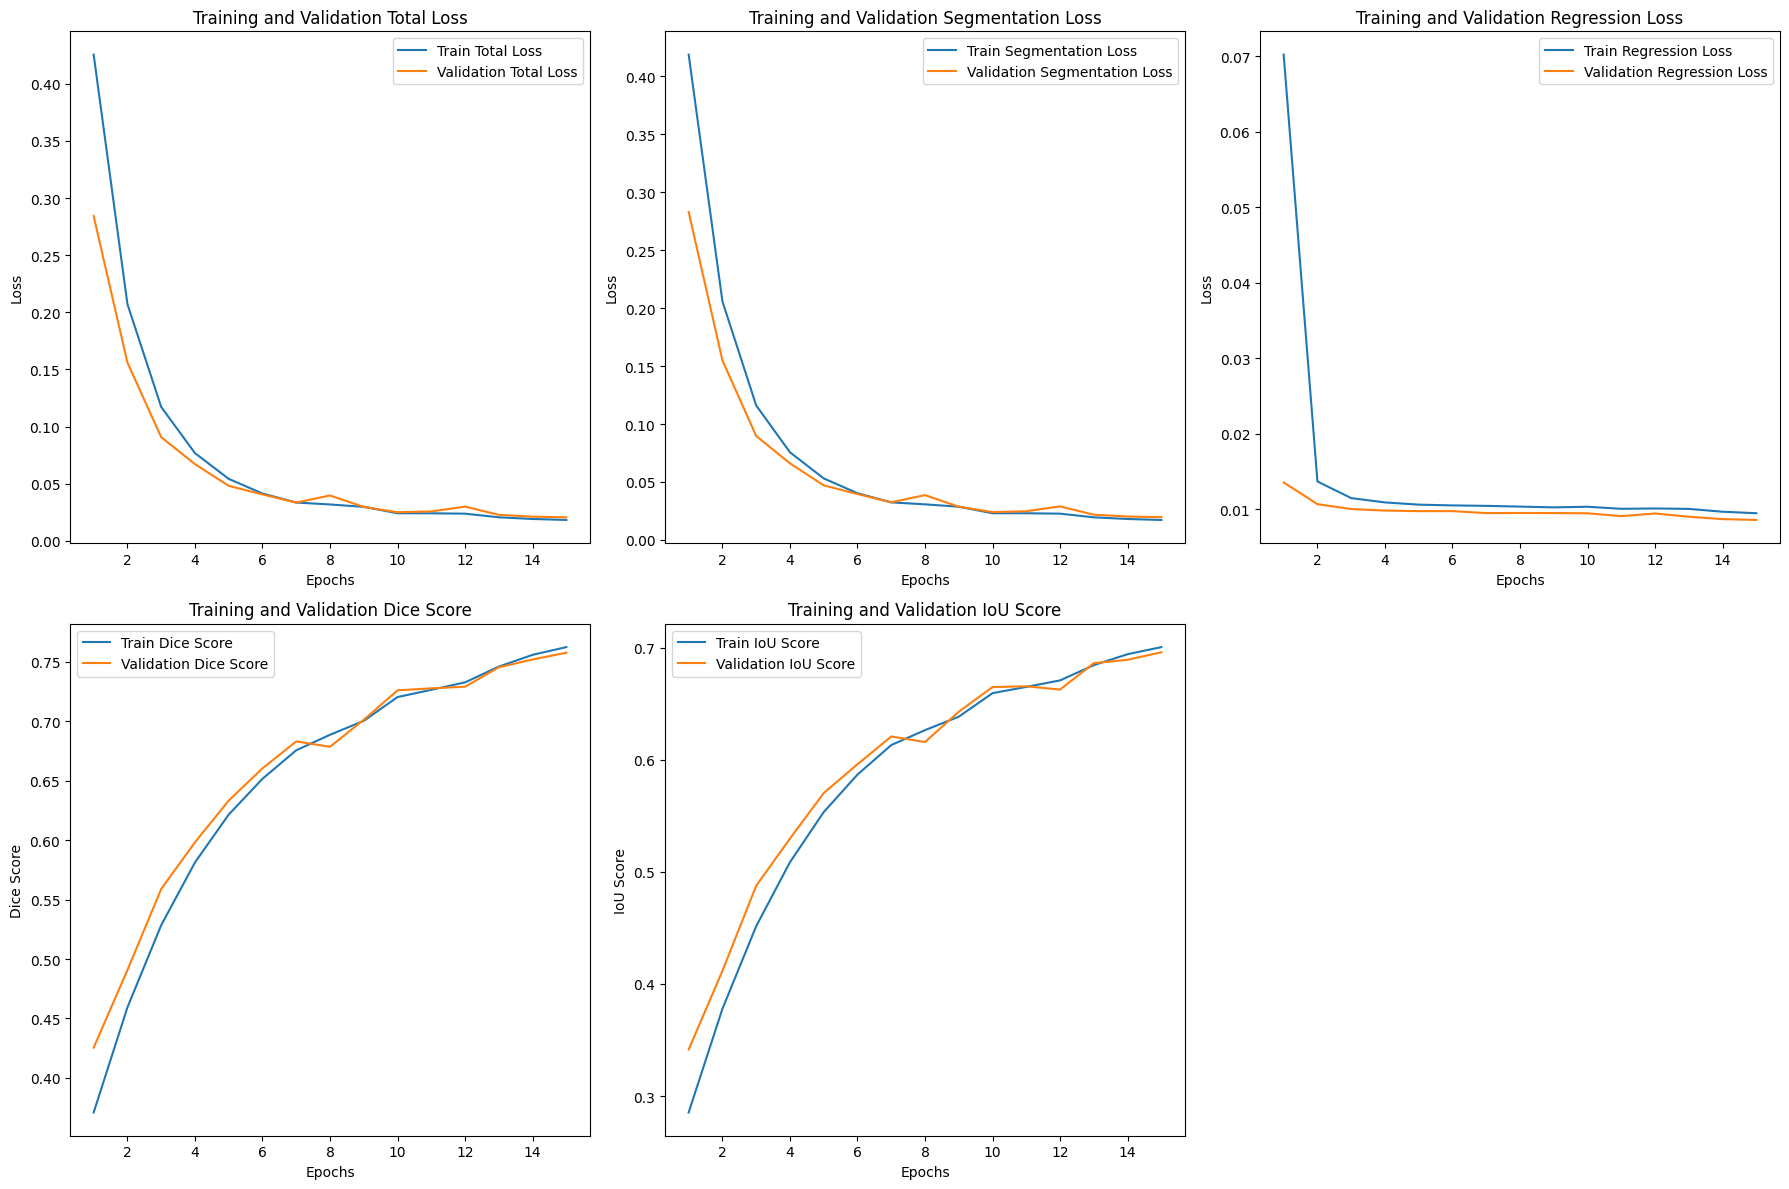

In [ ]:
# Cell 8: Enhanced Plotting Metrics for NIR U-Net

def plot_metrics(history_dict):
    epochs_range = range(1, len(history_dict['train_loss']) + 1)

    plt.figure(figsize=(20, 15))

    # Plot Total Loss
    plt.subplot(3, 3, 1)
    plt.plot(epochs_range, history_dict['train_loss'], label='Train Total Loss', linewidth=2)
    plt.plot(epochs_range, history_dict['val_loss'], label='Validation Total Loss', linewidth=2)
    plt.legend(loc='best')
    plt.title('Training and Validation Total Loss', fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    # Plot Segmentation Loss
    plt.subplot(3, 3, 2)
    plt.plot(epochs_range, history_dict['train_seg_loss'], label='Train Segmentation Loss', linewidth=2)
    plt.plot(epochs_range, history_dict['val_seg_loss'], label='Validation Segmentation Loss', linewidth=2)
    plt.legend(loc='best')
    plt.title('Training and Validation Segmentation Loss', fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Plot Regression Loss if available
    if CONFIG["MULTITASK"] and history_dict.get('train_reg_loss'):
        plt.subplot(3, 3, 3)
        plt.plot(epochs_range, history_dict['train_reg_loss'], label='Train Regression Loss', linewidth=2)
        plt.plot(epochs_range, history_dict['val_reg_loss'], label='Validation Regression Loss', linewidth=2)
        plt.legend(loc='best')
        plt.title('Training and Validation Regression Loss', fontsize=12, fontweight='bold')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
    
    # Plot Dice Score
    plt.subplot(3, 3, 4)
    plt.plot(epochs_range, history_dict['train_dice'], label='Train Dice Score', linewidth=2, color='green')
    plt.plot(epochs_range, history_dict['val_dice'], label='Validation Dice Score', linewidth=2, color='red')
    plt.legend(loc='best')
    plt.title('Training and Validation Dice Score', fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.grid(True, alpha=0.3)
    
    # Plot IoU Score
    plt.subplot(3, 3, 5)
    plt.plot(epochs_range, history_dict['train_iou'], label='Train IoU Score', linewidth=2, color='blue')
    plt.plot(epochs_range, history_dict['val_iou'], label='Validation IoU Score', linewidth=2, color='orange')
    plt.legend(loc='best')
    plt.title('Training and Validation IoU Score', fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.grid(True, alpha=0.3)

    # Plot Accuracy
    plt.subplot(3, 3, 6)
    plt.plot(epochs_range, history_dict['train_accuracy'], label='Train Accuracy', linewidth=2, color='purple')
    plt.plot(epochs_range, history_dict['val_accuracy'], label='Validation Accuracy', linewidth=2, color='brown')
    plt.legend(loc='best')
    plt.title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)

    # Plot Learning Rate
    if history_dict.get('learning_rates'):
        plt.subplot(3, 3, 7)
        plt.plot(epochs_range, history_dict['learning_rates'], linewidth=2, color='red')
        plt.title('Learning Rate Schedule', fontsize=12, fontweight='bold')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)

    # Plot Combined Metrics
    plt.subplot(3, 3, 8)
    plt.plot(epochs_range, history_dict['val_dice'], label='Validation Dice', linewidth=2, color='green')
    plt.plot(epochs_range, history_dict['val_iou'], label='Validation IoU', linewidth=2, color='blue')
    plt.plot(epochs_range, history_dict['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
    plt.legend(loc='best')
    plt.title('Validation Metrics Comparison', fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.grid(True, alpha=0.3)

    # Training Summary
    plt.subplot(3, 3, 9)
    plt.text(0.1, 0.8, f"Model: {CONFIG.get('MODEL_NAME', 'NIR U-Net')}", fontsize=12, fontweight='bold')
    plt.text(0.1, 0.7, f"Total Epochs: {len(epochs_range)}", fontsize=10)
    plt.text(0.1, 0.6, f"Best Val Dice: {max(history_dict['val_dice']):.4f}", fontsize=10)
    plt.text(0.1, 0.5, f"Best Val IoU: {max(history_dict['val_iou']):.4f}", fontsize=10)
    plt.text(0.1, 0.4, f"Best Val Accuracy: {max(history_dict['val_accuracy']):.4f}", fontsize=10)
    plt.text(0.1, 0.3, f"Final Learning Rate: {history_dict['learning_rates'][-1]:.2e}", fontsize=10)
    plt.text(0.1, 0.2, f"Image Size: {CONFIG['IMAGE_SIZE']}", fontsize=10)
    plt.text(0.1, 0.1, f"Batch Size: {CONFIG['BATCH_SIZE']}", fontsize=10)
    plt.title('Training Summary', fontsize=12, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.suptitle(f"{CONFIG.get('MODEL_NAME', 'NIR U-Net')} Training Metrics", fontsize=16, fontweight='bold', y=0.98)
    plt.show()

# Enhanced metrics summary function
def print_training_summary(history_dict):
    if not history_dict.get('train_loss', []):
        print("No training history available.")
        return
    
    epochs_completed = len(history_dict['train_loss'])
    best_val_dice = max(history_dict['val_dice'])
    best_val_iou = max(history_dict['val_iou'])
    best_val_acc = max(history_dict['val_accuracy'])
    
    print(f"\n{'='*80}")
    print(f"{CONFIG.get('MODEL_NAME', 'NIR U-Net')} TRAINING SUMMARY")
    print(f"{'='*80}")
    print(f"📊 Epochs Completed: {epochs_completed}/{CONFIG['NUM_EPOCHS']}")
    print(f"🎯 Best Validation Dice Score: {best_val_dice:.4f}")
    print(f"🎯 Best Validation IoU Score: {best_val_iou:.4f}")
    print(f"🎯 Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"📈 Final Learning Rate: {history_dict['learning_rates'][-1]:.2e}")
    print(f"💾 Checkpoints Saved: {epochs_completed}")
    print(f"📁 Checkpoint Directory: {CONFIG['CHECKPOINT_DIR']}")
    print(f"{'='*80}")

# Plot metrics if history is available
if 'history' in globals() and history.get('train_loss', []):
    print_training_summary(history)
    plot_metrics(history)
else:
    print("No training history to plot. Run the training loop first.")

# Cell 9: Enhanced Evaluation on Test Set for Transformer U-Net

def evaluate_model(model, loader):
    model.eval()
    total_loss = 0
    total_seg_loss = 0
    total_reg_loss = 0
    total_dice = 0
    total_iou = 0
    total_accuracy = 0
    total_correct = 0
    total_pixels = 0
    
    num_batches = len(loader)
    if num_batches == 0:
        print("Warning: Test DataLoader is empty. Evaluation cannot proceed.")
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    print("\n📊 Evaluating Transformer U-Net on Test Set...")
    progress_bar = tqdm(loader, desc="Test Evaluation", leave=False)

    with torch.no_grad():
        for batch_idx, data_batch in enumerate(progress_bar):
            try:
                if CONFIG["MULTITASK"]:
                    images, masks, coords = data_batch
                    images = images.to(CONFIG["DEVICE"], non_blocking=True)
                    masks = masks.to(CONFIG["DEVICE"], non_blocking=True)
                    coords = coords.to(CONFIG["DEVICE"], non_blocking=True)
                    
                    if use_amp:
                        with autocast():
                            seg_preds, reg_preds = model(images)
                            loss_seg = criterion_segmentation(seg_preds, masks)
                            loss_reg = criterion_regression(reg_preds, coords)
                            loss = loss_seg + 0.1 * loss_reg
                    else:
                        seg_preds, reg_preds = model(images)
                        loss_seg = criterion_segmentation(seg_preds, masks)
                        loss_reg = criterion_regression(reg_preds, coords)
                        loss = loss_seg + 0.1 * loss_reg
                    
                    total_reg_loss += loss_reg.item()
                else:
                    images, masks = data_batch
                    images = images.to(CONFIG["DEVICE"], non_blocking=True)
                    masks = masks.to(CONFIG["DEVICE"], non_blocking=True)
                    
                    if use_amp:
                        with autocast():
                            seg_preds = model(images)
                            loss_seg = criterion_segmentation(seg_preds, masks)
                            loss = loss_seg
                    else:
                        seg_preds = model(images)
                        loss_seg = criterion_segmentation(seg_preds, masks)
                        loss = loss_seg

                total_loss += loss.item()
                total_seg_loss += loss_seg.item()
                
                # Compute enhanced metrics
                dice = dice_score(seg_preds, masks)
                iou = iou_score(seg_preds, masks)
                accuracy = pixel_accuracy(seg_preds, masks)
                
                total_dice += dice.item()
                total_iou += iou.item()
                total_accuracy += accuracy.item()
                
                # Compute detailed pixel accuracy
                pred_labels = torch.argmax(seg_preds, dim=1)
                total_correct += (pred_labels == masks).sum().item()
                total_pixels += masks.numel()

                progress_bar.set_postfix(
                    dice=f"{total_dice/(batch_idx+1):.4f}",
                    iou=f"{total_iou/(batch_idx+1):.4f}",
                    acc=f"{total_accuracy/(batch_idx+1):.4f}"
                )
            except Exception as e:
                print(f"Error in evaluation batch {batch_idx}: {e}")
                continue

    # Calculate final metrics
    avg_loss = total_loss / num_batches
    avg_seg_loss = total_seg_loss / num_batches
    avg_reg_loss = total_reg_loss / num_batches if CONFIG["MULTITASK"] else 0
    avg_dice = total_dice / num_batches
    avg_iou = total_iou / num_batches
    avg_accuracy = total_accuracy / num_batches
    overall_pixel_accuracy = total_correct / total_pixels if total_pixels > 0 else 0.0

    print(f"\n🎯 TRANSFORMER U-NET TEST RESULTS:")
    print(f"{'='*60}")
    print(f"   📊 Total Loss: {avg_loss:.4f}")
    print(f"   🎭 Segmentation Loss: {avg_seg_loss:.4f}")
    if CONFIG["MULTITASK"]:
        print(f"   📍 Regression Loss: {avg_reg_loss:.6f}")
    print(f"   🎲 Dice Score: {avg_dice:.4f}")
    print(f"   🔗 IoU Score: {avg_iou:.4f}")
    print(f"   ✅ Batch Accuracy: {avg_accuracy:.4f}")
    print(f"   🎯 Overall Pixel Accuracy: {overall_pixel_accuracy:.4f}")
    print(f"{'='*60}")
    
    return avg_loss, avg_seg_loss, avg_reg_loss, avg_dice, avg_iou, avg_accuracy, overall_pixel_accuracy

# Load and evaluate the best Transformer U-Net model
best_model_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "best_transformer_unet.pth")
if os.path.exists(best_model_path):
    print(f"🔍 Loading best Transformer U-Net model from: {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=CONFIG["DEVICE"])
    
    eval_model = TransformerUNet(
        n_channels_in=1, 
        n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
        n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
        multitask=CONFIG["MULTITASK"]
    ).to(CONFIG["DEVICE"])
    eval_model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"📈 Model trained for {checkpoint['epoch']+1} epochs")
    print(f"🎯 Best validation Dice: {checkpoint.get('metrics', {}).get('val_dice', 'N/A')}")
    
    if test_loader and len(test_loader.dataset) > 0:
        if len(test_loader) > 0:
            test_results = evaluate_model(eval_model, test_loader)
            
            # Save evaluation results
            eval_results_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "transformer_unet_evaluation_results.txt")
            with open(eval_results_path, 'w') as f:
                f.write(f"Transformer U-Net Evaluation Results\n")
                f.write(f"{'='*60}\n")
                f.write(f"Model: {CONFIG.get('MODEL_NAME', 'Transformer U-Net')}\n")
                f.write(f"Architecture: Transformer U-Net with Attention Gates\n")
                f.write(f"Transformer Layers: {CONFIG['NUM_LAYERS']}\n")
                f.write(f"Attention Heads: {CONFIG['NUM_HEADS']}\n")
                f.write(f"Embedding Dimension: {CONFIG['EMBED_DIM']}\n")
                f.write(f"Test Loss: {test_results[0]:.4f}\n")
                f.write(f"Segmentation Loss: {test_results[1]:.4f}\n")
                if CONFIG["MULTITASK"]:
                    f.write(f"Regression Loss: {test_results[2]:.6f}\n")
                f.write(f"Dice Score: {test_results[3]:.4f}\n")
                f.write(f"IoU Score: {test_results[4]:.4f}\n")
                f.write(f"Accuracy: {test_results[5]:.4f}\n")
                f.write(f"Overall Pixel Accuracy: {test_results[6]:.4f}\n")
                f.write(f"Model Parameters: {count_parameters(eval_model):,}\n")
            print(f"💾 Evaluation results saved to: {eval_results_path}")
        else:
            print("Test DataLoader is empty. Skipping evaluation.")
    else:
        print("Test dataset is empty. Skipping evaluation.")
else:
    print("❌ Best Transformer U-Net model checkpoint not found. Run training first!")
    print(f"Expected path: {best_model_path}")
    
    # List available checkpoints
    if os.path.exists(CONFIG["CHECKPOINT_DIR"]):
        checkpoints = [f for f in os.listdir(CONFIG["CHECKPOINT_DIR"]) if f.endswith('.pth')]
        if checkpoints:
            print(f"Available checkpoints in {CONFIG['CHECKPOINT_DIR']}:")
            for cp in sorted(checkpoints):
                print(f"  - {cp}")
        else:
            print(f"No checkpoints found in {CONFIG['CHECKPOINT_DIR']}")
    else:
        print(f"Checkpoint directory {CONFIG['CHECKPOINT_DIR']} does not exist.")

# Function to compare different model architectures
def compare_model_performance(checkpoint_paths, model_names):
    """Compare performance of different model checkpoints"""
    if len(checkpoint_paths) != len(model_names):
        print("Error: Number of checkpoint paths must match number of model names")
        return
    
    results = []
    for i, (checkpoint_path, model_name) in enumerate(zip(checkpoint_paths, model_names)):
        if os.path.exists(checkpoint_path):
            print(f"\nEvaluating {model_name}...")
            checkpoint = torch.load(checkpoint_path, map_location=CONFIG["DEVICE"])
            
            eval_model = TransformerUNet(
                n_channels_in=1, 
                n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
                n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
                multitask=CONFIG["MULTITASK"]
            ).to(CONFIG["DEVICE"])
            eval_model.load_state_dict(checkpoint['model_state_dict'])
            
            if test_loader and len(test_loader) > 0:
                test_results = evaluate_model(eval_model, test_loader)
                results.append({
                    'model': model_name,
                    'dice': test_results[3],
                    'iou': test_results[4],
                    'accuracy': test_results[5],
                    'parameters': count_parameters(eval_model)
                })
            
            del eval_model
            torch.cuda.empty_cache()
        else:
            print(f"Checkpoint not found: {checkpoint_path}")
    
    # Display comparison
    if results:
        print(f"\n📊 MODEL PERFORMANCE COMPARISON:")
        print(f"{'='*80}")
        print(f"{'Model':<25} {'Dice':<8} {'IoU':<8} {'Accuracy':<10} {'Parameters':<12}")
        print(f"{'-'*80}")
        for result in results:
            print(f"{result['model']:<25} {result['dice']:<8.4f} {result['iou']:<8.4f} {result['accuracy']:<10.4f} {result['parameters']:<12,}")
        print(f"{'='*80}")

print("✅ Enhanced evaluation functions ready for Transformer U-Net!")

In [ ]:
# Cell 9: Enhanced Evaluation on Test Set for NIR U-Net

def evaluate_model(model, loader):
    model.eval()
    total_loss = 0
    total_seg_loss = 0
    total_reg_loss = 0
    total_dice = 0
    total_iou = 0
    total_accuracy = 0
    total_correct = 0
    total_pixels = 0
    
    num_batches = len(loader)
    if num_batches == 0:
        print("Warning: Test DataLoader is empty. Evaluation cannot proceed.")
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    print("\n📊 Evaluating NIR U-Net on Test Set...")
    progress_bar = tqdm(loader, desc="Test Evaluation", leave=False)

    with torch.no_grad():
        for batch_idx, data_batch in enumerate(progress_bar):
            try:
                if CONFIG["MULTITASK"]:
                    images, masks, coords = data_batch
                    images = images.to(CONFIG["DEVICE"], non_blocking=True)
                    masks = masks.to(CONFIG["DEVICE"], non_blocking=True)
                    coords = coords.to(CONFIG["DEVICE"], non_blocking=True)
                    
                    if use_amp:
                        with autocast():
                            seg_preds, reg_preds = model(images)
                            loss_seg = criterion_segmentation(seg_preds, masks)
                            loss_reg = criterion_regression(reg_preds, coords)
                            loss = loss_seg + 0.1 * loss_reg
                    else:
                        seg_preds, reg_preds = model(images)
                        loss_seg = criterion_segmentation(seg_preds, masks)
                        loss_reg = criterion_regression(reg_preds, coords)
                        loss = loss_seg + 0.1 * loss_reg
                    
                    total_reg_loss += loss_reg.item()
                else:
                    images, masks = data_batch
                    images = images.to(CONFIG["DEVICE"], non_blocking=True)
                    masks = masks.to(CONFIG["DEVICE"], non_blocking=True)
                    
                    if use_amp:
                        with autocast():
                            seg_preds = model(images)
                            loss_seg = criterion_segmentation(seg_preds, masks)
                            loss = loss_seg
                    else:
                        seg_preds = model(images)
                        loss_seg = criterion_segmentation(seg_preds, masks)
                        loss = loss_seg

                total_loss += loss.item()
                total_seg_loss += loss_seg.item()
                
                # Compute enhanced metrics
                dice = dice_score(seg_preds, masks)
                iou = iou_score(seg_preds, masks)
                accuracy = pixel_accuracy(seg_preds, masks)
                
                total_dice += dice.item()
                total_iou += iou.item()
                total_accuracy += accuracy.item()
                
                # Compute detailed pixel accuracy
                pred_labels = torch.argmax(seg_preds, dim=1)
                total_correct += (pred_labels == masks).sum().item()
                total_pixels += masks.numel()

                progress_bar.set_postfix(
                    dice=f"{total_dice/(batch_idx+1):.4f}",
                    iou=f"{total_iou/(batch_idx+1):.4f}",
                    acc=f"{total_accuracy/(batch_idx+1):.4f}"
                )
            except Exception as e:
                print(f"Error in evaluation batch {batch_idx}: {e}")
                continue

    # Calculate final metrics
    avg_loss = total_loss / num_batches
    avg_seg_loss = total_seg_loss / num_batches
    avg_reg_loss = total_reg_loss / num_batches if CONFIG["MULTITASK"] else 0
    avg_dice = total_dice / num_batches
    avg_iou = total_iou / num_batches
    avg_accuracy = total_accuracy / num_batches
    overall_pixel_accuracy = total_correct / total_pixels if total_pixels > 0 else 0.0

    print(f"\n🎯 NIR U-NET TEST RESULTS:")
    print(f"{'='*60}")
    print(f"   📊 Total Loss: {avg_loss:.4f}")
    print(f"   🎭 Segmentation Loss: {avg_seg_loss:.4f}")
    if CONFIG["MULTITASK"]:
        print(f"   📍 Regression Loss: {avg_reg_loss:.6f}")
    print(f"   🎲 Dice Score: {avg_dice:.4f}")
    print(f"   🔗 IoU Score: {avg_iou:.4f}")
    print(f"   ✅ Batch Accuracy: {avg_accuracy:.4f}")
    print(f"   🎯 Overall Pixel Accuracy: {overall_pixel_accuracy:.4f}")
    print(f"{'='*60}")
    
    return avg_loss, avg_seg_loss, avg_reg_loss, avg_dice, avg_iou, avg_accuracy, overall_pixel_accuracy

# Load and evaluate the best NIR U-Net model
best_model_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "best_model_nir_unet.pth")
if os.path.exists(best_model_path):
    print(f"🔍 Loading best NIR U-Net model from: {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=CONFIG["DEVICE"])
    
    eval_model = NIRUNet(n_channels_in=1, 
                        n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
                        n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
                        multitask=CONFIG["MULTITASK"]).to(CONFIG["DEVICE"])
    eval_model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"📈 Model trained for {checkpoint['epoch']+1} epochs")
    print(f"🎯 Best validation Dice: {checkpoint.get('best_val_metric', 'N/A')}")
    
    if test_loader and len(test_loader.dataset) > 0:
        if len(test_loader) > 0:
            test_results = evaluate_model(eval_model, test_loader)
            
            # Save evaluation results
            eval_results_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "evaluation_results.txt")
            with open(eval_results_path, 'w') as f:
                f.write(f"NIR U-Net Evaluation Results\n")
                f.write(f"{'='*60}\n")
                f.write(f"Model: {CONFIG.get('MODEL_NAME', 'NIR U-Net')}\n")
                f.write(f"Test Loss: {test_results[0]:.4f}\n")
                f.write(f"Segmentation Loss: {test_results[1]:.4f}\n")
                if CONFIG["MULTITASK"]:
                    f.write(f"Regression Loss: {test_results[2]:.6f}\n")
                f.write(f"Dice Score: {test_results[3]:.4f}\n")
                f.write(f"IoU Score: {test_results[4]:.4f}\n")
                f.write(f"Accuracy: {test_results[5]:.4f}\n")
                f.write(f"Overall Pixel Accuracy: {test_results[6]:.4f}\n")
            print(f"💾 Evaluation results saved to: {eval_results_path}")
        else:
            print("Test DataLoader is empty. Skipping evaluation.")
    else:
        print("Test dataset is empty. Skipping evaluation.")
else:
    print("❌ Best NIR U-Net model checkpoint not found. Run training first!")
    print(f"Expected path: {best_model_path}")
    
    # List available checkpoints
    if os.path.exists(CONFIG["CHECKPOINT_DIR"]):
        checkpoints = [f for f in os.listdir(CONFIG["CHECKPOINT_DIR"]) if f.endswith('.pth')]
        if checkpoints:
            print(f"Available checkpoints in {CONFIG['CHECKPOINT_DIR']}:
            for cp in sorted(checkpoints):
                print(f"  - {cp}")
        else:
            print(f"No checkpoints found in {CONFIG['CHECKPOINT_DIR']}")
    else:
        print(f"Checkpoint directory {CONFIG['CHECKPOINT_DIR']} does not exist.")

# Cell 10: Enhanced Prediction & Visualization for Transformer U-Net

def predict_and_visualize(model, dataset, num_samples=3):
    model.eval()
    
    if len(dataset) == 0:
        print("Dataset is empty, cannot visualize predictions.")
        return

    num_samples = min(num_samples, len(dataset))
    if num_samples == 0:
        print("No samples to visualize.")
        return

    print(f"\n🖼️ Visualizing {num_samples} Transformer U-Net predictions...")
    
    # Get random samples
    sample_indices = random.sample(range(len(dataset)), num_samples)
    
    with torch.no_grad():
        for idx, i in enumerate(sample_indices):
            if CONFIG["MULTITASK"]:
                image, gt_mask, gt_coords = dataset[i]
            else:
                image, gt_mask = dataset[i]
                gt_coords = None

            # Prepare image for model
            image_batch = image.unsqueeze(0).to(CONFIG["DEVICE"])

            # Model prediction with attention visualization
            if use_amp:
                with autocast():
                    if CONFIG["MULTITASK"]:
                        pred_seg_logits, pred_coords_norm = model(image_batch)
                    else:
                        pred_seg_logits = model(image_batch)
                        pred_coords_norm = None
            else:
                if CONFIG["MULTITASK"]:
                    pred_seg_logits, pred_coords_norm = model(image_batch)
                else:
                    pred_seg_logits = model(image_batch)
                    pred_coords_norm = None

            # Process predictions
            pred_mask_probs = torch.softmax(pred_seg_logits, dim=1)
            pred_mask = torch.argmax(pred_mask_probs, dim=1).squeeze(0).cpu().numpy()

            # Denormalize image for display (reverse ImageNet normalization)
            img_display = (image.cpu().squeeze().numpy() * 0.229) + 0.485
            img_display = np.clip(img_display, 0, 1)
            gt_mask_display = gt_mask.cpu().squeeze().numpy()

            # Calculate metrics for this sample
            gt_mask_tensor = gt_mask.unsqueeze(0).to(CONFIG["DEVICE"])
            sample_dice = dice_score(pred_seg_logits, gt_mask_tensor).item()
            sample_iou = iou_score(pred_seg_logits, gt_mask_tensor).item()
            sample_accuracy = pixel_accuracy(pred_seg_logits, gt_mask_tensor).item()

            plt.figure(figsize=(24, 6))
            
            # Original Image with coordinates
            plt.subplot(1, 5, 1)
            plt.imshow(img_display, cmap='gray')
            plt.title(f"Original NIR Image #{idx+1}", fontsize=14, fontweight='bold')
            
            if CONFIG["MULTITASK"] and gt_coords is not None:
                img_h, img_w = CONFIG["IMAGE_SIZE"]
                # Ground truth coordinates
                gt_x = gt_coords[0].item() * img_w
                gt_y = gt_coords[1].item() * img_h
                plt.scatter([gt_x], [gt_y], c='lime', marker='o', s=150, 
                           label=f'GT ACF ({gt_x:.0f},{gt_y:.0f})', 
                           alpha=0.9, edgecolors='black', linewidth=2)
                
                # Predicted coordinates
                if pred_coords_norm is not None:
                    pred_coords_cpu = pred_coords_norm.squeeze(0).cpu()
                    pred_x = pred_coords_cpu[0].item() * img_w
                    pred_y = pred_coords_cpu[1].item() * img_h
                    plt.scatter([pred_x], [pred_y], c='red', marker='x', s=150, 
                               label=f'Pred ACF ({pred_x:.0f},{pred_y:.0f})', 
                               alpha=0.9, linewidth=4)
                    
                    # Calculate distance error
                    distance_error = np.sqrt((gt_x - pred_x)**2 + (gt_y - pred_y)**2)
                    plt.title(f"Original NIR Image #{idx+1}\nCoord Error: {distance_error:.1f}px", 
                             fontsize=12, fontweight='bold')
                
                plt.legend(fontsize='small', loc='upper right')
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(1, 5, 2)
            plt.imshow(gt_mask_display, cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1)
            plt.title("Ground Truth Mask", fontsize=14, fontweight='bold')
            plt.colorbar(shrink=0.8)
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 5, 3)
            plt.imshow(pred_mask, cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1)
            plt.title(f"Transformer U-Net Prediction\nDice: {sample_dice:.3f}", fontsize=14, fontweight='bold')
            plt.colorbar(shrink=0.8)
            plt.axis('off')
            
            # Prediction Confidence
            plt.subplot(1, 5, 4)
            confidence_map = torch.max(pred_mask_probs, dim=1)[0].squeeze(0).cpu().numpy()
            plt.imshow(confidence_map, cmap='viridis', vmin=0, vmax=1)
            plt.title(f"Prediction Confidence\nIoU: {sample_iou:.3f}", fontsize=12, fontweight='bold')
            plt.colorbar(shrink=0.8)
            plt.axis('off')
            
            # Class Probability Distribution
            plt.subplot(1, 5, 5)
            class_probs = torch.mean(pred_mask_probs.squeeze(0), dim=(1, 2)).cpu().numpy()
            class_names = [f'Class {i}' for i in range(CONFIG["NUM_CLASSES_SEG"])]
            bars = plt.bar(class_names, class_probs, color=['blue', 'red', 'green'][:CONFIG["NUM_CLASSES_SEG"]])
            plt.title(f"Average Class Probabilities\nAcc: {sample_accuracy:.3f}", fontsize=12, fontweight='bold')
            plt.ylabel('Probability')
            plt.ylim(0, 1)
            for bar, prob in zip(bars, class_probs):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{prob:.3f}', ha='center', va='bottom', fontsize=10)
            
            plt.tight_layout()
            plt.suptitle(f"Transformer U-Net Prediction Sample {idx+1}", fontsize=16, fontweight='bold', y=1.02)
            plt.show()

            # Print detailed metrics for this sample
            print(f"Sample {idx+1} Metrics:")
            print(f"  Dice Score: {sample_dice:.4f}")
            print(f"  IoU Score: {sample_iou:.4f}")
            print(f"  Accuracy: {sample_accuracy:.4f}")
            if CONFIG["MULTITASK"] and gt_coords is not None and pred_coords_norm is not None:
                print(f"  Coordinate Error: {distance_error:.2f} pixels")
            print(f"  Class Distribution: {[f'{p:.3f}' for p in class_probs]}")
            print("-" * 50)

# Enhanced model loading and visualization
def load_and_visualize_transformer_model(checkpoint_path, dataset, num_samples=3):
    """Load a specific Transformer U-Net checkpoint and visualize predictions"""
    if not os.path.exists(checkpoint_path):
        print(f"❌ Checkpoint not found: {checkpoint_path}")
        return
    
    print(f"🔍 Loading Transformer U-Net from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=CONFIG["DEVICE"])
    
    vis_model = TransformerUNet(
        n_channels_in=1, 
        n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
        n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
        multitask=CONFIG["MULTITASK"]
    ).to(CONFIG["DEVICE"])
    vis_model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"📈 Model epoch: {checkpoint.get('epoch', 'N/A')}")
    if 'metrics' in checkpoint:
        print(f"🎯 Validation Dice: {checkpoint['metrics'].get('val_dice', 'N/A'):.4f}")
        print(f"🎯 Validation IoU: {checkpoint['metrics'].get('val_iou', 'N/A'):.4f}")
    
    predict_and_visualize(vis_model, dataset, num_samples)

# Function to visualize attention maps (if accessible)
def visualize_attention_maps(model, image, layer_name='transformer'):
    """Visualize attention maps from Transformer layers"""
    model.eval()
    
    # This is a simplified version - actual implementation would require
    # hooks to extract attention weights from the transformer module
    print("🔍 Attention visualization would require model hooks to extract attention weights")
    print("This is a placeholder for attention visualization functionality")

# Visualize predictions with the best model
best_model_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "best_transformer_unet.pth")

if 'eval_model' in locals() and isinstance(eval_model, nn.Module):
    predict_and_visualize(eval_model, test_dataset, num_samples=4)
elif os.path.exists(best_model_path):
    load_and_visualize_transformer_model(best_model_path, test_dataset, num_samples=4)
else:
    print("❌ No trained Transformer U-Net model available for visualization.")
    print(f"Expected path: {best_model_path}")
    
    # Offer to load latest checkpoint
    latest_checkpoint = os.path.join(CONFIG["CHECKPOINT_DIR"], "latest_transformer_unet.pth")
    if os.path.exists(latest_checkpoint):
        print(f"💡 Found latest checkpoint: {latest_checkpoint}")
        response = input("Would you like to visualize with the latest checkpoint? (y/n): ")
        if response.lower() == 'y':
            load_and_visualize_transformer_model(latest_checkpoint, test_dataset, num_samples=4)
    else:
        print("Please train a Transformer U-Net model first!")

# Additional function to compare multiple Transformer U-Net checkpoints
def compare_transformer_checkpoints(checkpoint_paths, dataset, sample_idx=0):
    """Compare predictions from multiple Transformer U-Net checkpoints on the same sample"""
    if len(dataset) == 0:
        print("Dataset is empty.")
        return
    
    num_models = len(checkpoint_paths)
    if num_models == 0:
        print("No checkpoint paths provided.")
        return
    
    fig, axes = plt.subplots(3, num_models + 1, figsize=(5*(num_models+1), 15))
    if num_models == 1:
        axes = axes.reshape(-1, 1)
    
    # Load sample
    if CONFIG["MULTITASK"]:
        image, gt_mask, gt_coords = dataset[sample_idx]
    else:
        image, gt_mask = dataset[sample_idx]
    
    # Show original image and ground truth
    img_display = (image.cpu().squeeze().numpy() * 0.229) + 0.485
    img_display = np.clip(img_display, 0, 1)
    
    axes[0, 0].imshow(img_display, cmap='gray')
    axes[0, 0].set_title("Original Image", fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(gt_mask.cpu().squeeze().numpy(), cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1)
    axes[1, 0].set_title("Ground Truth", fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[2, 0].axis('off')  # Empty space for symmetry
    
    # Load and compare models
    for i, checkpoint_path in enumerate(checkpoint_paths):
        if not os.path.exists(checkpoint_path):
            print(f"❌ Checkpoint not found: {checkpoint_path}")
            continue
        
        checkpoint = torch.load(checkpoint_path, map_location=CONFIG["DEVICE"])
        model = TransformerUNet(
            n_channels_in=1, 
            n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
            n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
            multitask=CONFIG["MULTITASK"]
        ).to(CONFIG["DEVICE"])
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        with torch.no_grad():
            image_batch = image.unsqueeze(0).to(CONFIG["DEVICE"])
            if CONFIG["MULTITASK"]:
                pred_seg_logits, _ = model(image_batch)
            else:
                pred_seg_logits = model(image_batch)
            
            pred_mask = torch.argmax(pred_seg_logits, dim=1).squeeze(0).cpu().numpy()
            confidence_map = torch.max(torch.softmax(pred_seg_logits, dim=1), dim=1)[0].squeeze(0).cpu().numpy()
            
            # Calculate metrics
            gt_mask_tensor = gt_mask.unsqueeze(0).to(CONFIG["DEVICE"])
            dice = dice_score(pred_seg_logits, gt_mask_tensor).item()
            
            # Display prediction
            axes[0, i+1].imshow(pred_mask, cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1)
            axes[0, i+1].set_title(f"Epoch {checkpoint.get('epoch', 'N/A')}\nDice: {dice:.4f}", fontweight='bold')
            axes[0, i+1].axis('off')
            
            # Display confidence
            axes[1, i+1].imshow(confidence_map, cmap='viridis', vmin=0, vmax=1)
            axes[1, i+1].set_title(f"Confidence", fontweight='bold')
            axes[1, i+1].axis('off')
            
            # Display metrics
            metrics_text = f"Dice: {dice:.4f}\nEpoch: {checkpoint.get('epoch', 'N/A')}"
            if 'metrics' in checkpoint:
                val_dice = checkpoint['metrics'].get('val_dice', 'N/A')
                metrics_text += f"\nVal Dice: {val_dice:.4f}" if val_dice != 'N/A' else "\nVal Dice: N/A"
            
            axes[2, i+1].text(0.1, 0.5, metrics_text, fontsize=10, transform=axes[2, i+1].transAxes,
                             verticalalignment='center')
            axes[2, i+1].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Transformer U-Net Checkpoint Comparison", fontsize=16, fontweight='bold', y=0.98)
    plt.show()

print("✅ Enhanced visualization functions ready for Transformer U-Net!")

🔍 Loading best model from: checkpoints_fast_unet\best_model.pth

📊 Evaluating on Test Set...

📊 Evaluating on Test Set...



🎯 TEST RESULTS:
   Total Loss: 0.0196
   Segmentation Loss: 0.0187
   Regression Loss: 0.0085
   Dice Score: 0.7607
   IoU Score: 0.6990
   Pixel Accuracy: 0.9960



🖼️ Visualizing 3 predictions...


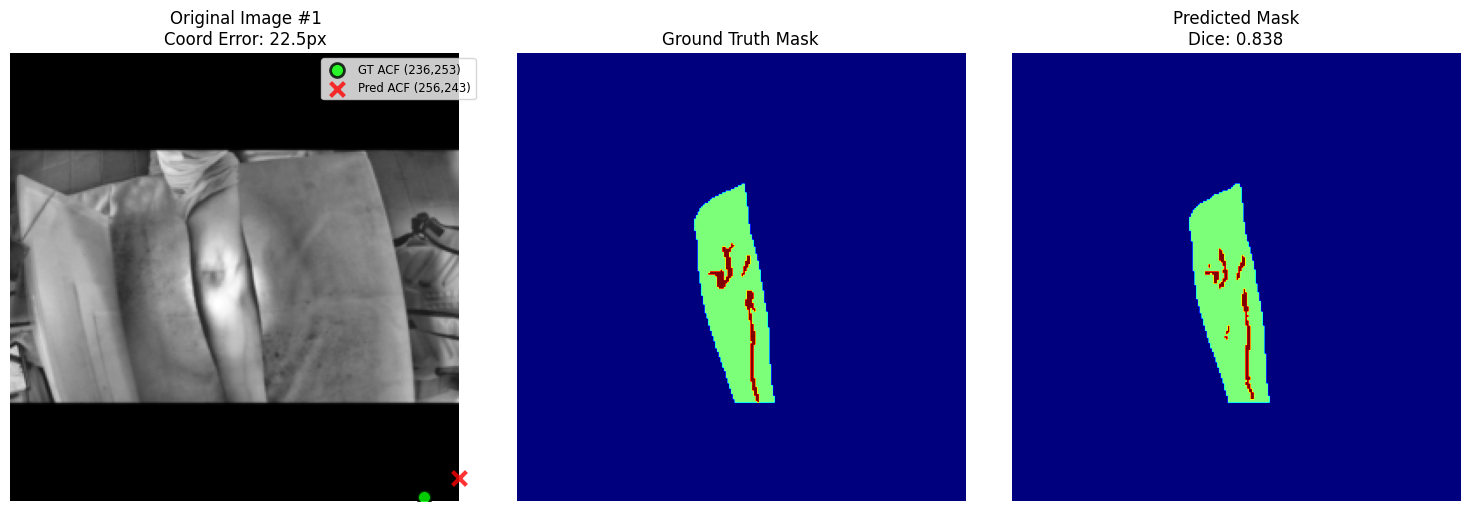

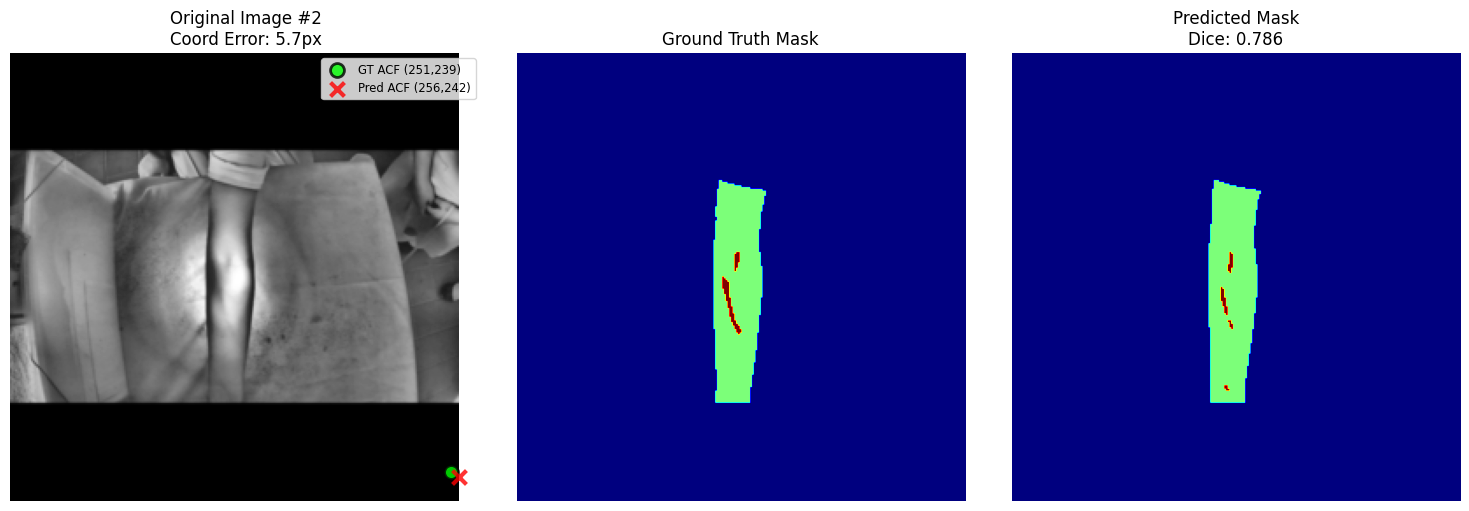

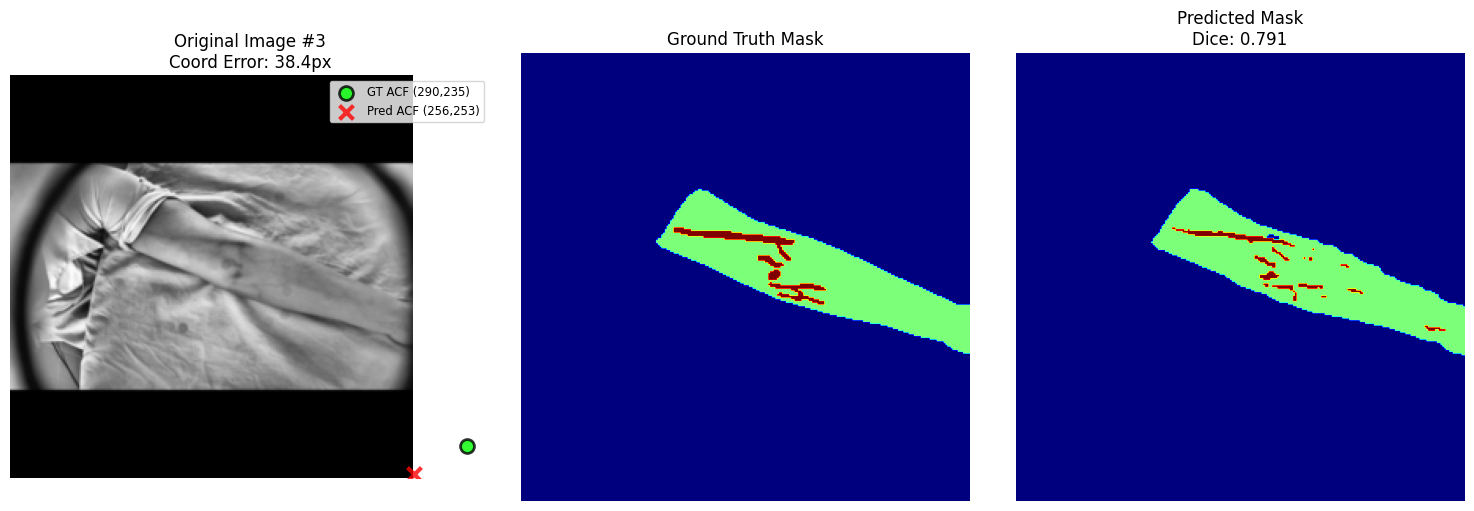

In [ ]:
# Cell 10: Enhanced Prediction & Visualization for NIR U-Net

def predict_and_visualize(model, dataset, num_samples=3):
    model.eval()
    
    if len(dataset) == 0:
        print("Dataset is empty, cannot visualize predictions.")
        return

    num_samples = min(num_samples, len(dataset))
    if num_samples == 0:
        print("No samples to visualize.")
        return

    print(f"\n🖼️ Visualizing {num_samples} NIR U-Net predictions...")
    
    # Get random samples
    sample_indices = random.sample(range(len(dataset)), num_samples)
    
    with torch.no_grad():
        for idx, i in enumerate(sample_indices):
            if CONFIG["MULTITASK"]:
                image, gt_mask, gt_coords = dataset[i]
            else:
                image, gt_mask = dataset[i]
                gt_coords = None

            # Prepare image for model
            image_batch = image.unsqueeze(0).to(CONFIG["DEVICE"])

            # Model prediction
            if use_amp:
                with autocast():
                    if CONFIG["MULTITASK"]:
                        pred_seg_logits, pred_coords_norm = model(image_batch)
                    else:
                        pred_seg_logits = model(image_batch)
                        pred_coords_norm = None
            else:
                if CONFIG["MULTITASK"]:
                    pred_seg_logits, pred_coords_norm = model(image_batch)
                else:
                    pred_seg_logits = model(image_batch)
                    pred_coords_norm = None

            # Process predictions
            pred_mask_probs = torch.softmax(pred_seg_logits, dim=1)
            pred_mask = torch.argmax(pred_mask_probs, dim=1).squeeze(0).cpu().numpy()

            # Denormalize image for display (reverse ImageNet normalization)
            img_display = (image.cpu().squeeze().numpy() * 0.229) + 0.485
            img_display = np.clip(img_display, 0, 1)
            gt_mask_display = gt_mask.cpu().squeeze().numpy()

            # Calculate metrics for this sample
            gt_mask_tensor = gt_mask.unsqueeze(0).to(CONFIG["DEVICE"])
            sample_dice = dice_score(pred_seg_logits, gt_mask_tensor).item()
            sample_iou = iou_score(pred_seg_logits, gt_mask_tensor).item()
            sample_accuracy = pixel_accuracy(pred_seg_logits, gt_mask_tensor).item()

            plt.figure(figsize=(20, 6))
            
            # Original Image with coordinates
            plt.subplot(1, 4, 1)
            plt.imshow(img_display, cmap='gray')
            plt.title(f"Original NIR Image #{idx+1}", fontsize=14, fontweight='bold')
            
            if CONFIG["MULTITASK"] and gt_coords is not None:
                img_h, img_w = CONFIG["IMAGE_SIZE"]
                # Ground truth coordinates
                gt_x = gt_coords[0].item() * img_w
                gt_y = gt_coords[1].item() * img_h
                plt.scatter([gt_x], [gt_y], c='lime', marker='o', s=150, 
                           label=f'GT ACF ({gt_x:.0f},{gt_y:.0f})', 
                           alpha=0.9, edgecolors='black', linewidth=2)
                
                # Predicted coordinates
                if pred_coords_norm is not None:
                    pred_coords_cpu = pred_coords_norm.squeeze(0).cpu()
                    pred_x = pred_coords_cpu[0].item() * img_w
                    pred_y = pred_coords_cpu[1].item() * img_h
                    plt.scatter([pred_x], [pred_y], c='red', marker='x', s=150, 
                               label=f'Pred ACF ({pred_x:.0f},{pred_y:.0f})', 
                               alpha=0.9, linewidth=4)
                    
                    # Calculate distance error
                    distance_error = np.sqrt((gt_x - pred_x)**2 + (gt_y - pred_y)**2)
                    plt.title(f"Original NIR Image #{idx+1}\nCoord Error: {distance_error:.1f}px", 
                             fontsize=12, fontweight='bold')
                
                plt.legend(fontsize='small', loc='upper right')
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(1, 4, 2)
            plt.imshow(gt_mask_display, cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1)
            plt.title("Ground Truth Mask", fontsize=14, fontweight='bold')
            plt.colorbar(shrink=0.8)
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 4, 3)
            plt.imshow(pred_mask, cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1)
            plt.title(f"Predicted Mask\nDice: {sample_dice:.3f}", fontsize=14, fontweight='bold')
            plt.colorbar(shrink=0.8)
            plt.axis('off')
            
            # Prediction Confidence
            plt.subplot(1, 4, 4)
            # Show confidence as max probability across classes
            confidence_map = torch.max(pred_mask_probs, dim=1)[0].squeeze(0).cpu().numpy()
            plt.imshow(confidence_map, cmap='viridis', vmin=0, vmax=1)
            plt.title(f"Prediction Confidence\nIoU: {sample_iou:.3f} | Acc: {sample_accuracy:.3f}", 
                     fontsize=12, fontweight='bold')
            plt.colorbar(shrink=0.8)
            plt.axis('off')
            
            plt.tight_layout()
            plt.suptitle(f"NIR U-Net Prediction Sample {idx+1}", fontsize=16, fontweight='bold', y=1.02)
            plt.show()

            # Print detailed metrics for this sample
            print(f"Sample {idx+1} Metrics:")
            print(f"  Dice Score: {sample_dice:.4f}")
            print(f"  IoU Score: {sample_iou:.4f}")
            print(f"  Accuracy: {sample_accuracy:.4f}")
            if CONFIG["MULTITASK"] and gt_coords is not None and pred_coords_norm is not None:
                print(f"  Coordinate Error: {distance_error:.2f} pixels")
            print("-" * 50)

# Enhanced model loading and visualization
def load_and_visualize_model(checkpoint_path, dataset, num_samples=3):
    """Load a specific checkpoint and visualize predictions"""
    if not os.path.exists(checkpoint_path):
        print(f"❌ Checkpoint not found: {checkpoint_path}")
        return
    
    print(f"🔍 Loading model from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=CONFIG["DEVICE"])
    
    vis_model = NIRUNet(n_channels_in=1, 
                       n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
                       n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
                       multitask=CONFIG["MULTITASK"]).to(CONFIG["DEVICE"])
    vis_model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"📈 Model epoch: {checkpoint.get('epoch', 'N/A')}")
    print(f"🎯 Validation Dice: {checkpoint.get('val_dice', 'N/A'):.4f}")
    
    predict_and_visualize(vis_model, dataset, num_samples)

# Visualize predictions with the best model
best_model_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "best_model_nir_unet.pth")

if 'eval_model' in locals() and isinstance(eval_model, nn.Module):
    predict_and_visualize(eval_model, test_dataset, num_samples=4)
elif os.path.exists(best_model_path):
    load_and_visualize_model(best_model_path, test_dataset, num_samples=4)
else:
    print("❌ No trained NIR U-Net model available for visualization.")
    print(f"Expected path: {best_model_path}")
    
    # Offer to load latest checkpoint
    latest_checkpoint = os.path.join(CONFIG["CHECKPOINT_DIR"], "latest_checkpoint.pth")
    if os.path.exists(latest_checkpoint):
        print(f"💡 Found latest checkpoint: {latest_checkpoint}")
        response = input("Would you like to visualize with the latest checkpoint? (y/n): ")
        if response.lower() == 'y':
            load_and_visualize_model(latest_checkpoint, test_dataset, num_samples=4)
    else:
        print("Please train a model first!")

# Additional function to compare multiple checkpoints
def compare_checkpoints(checkpoint_paths, dataset, sample_idx=0):
    """Compare predictions from multiple checkpoints on the same sample"""
    if len(dataset) == 0:
        print("Dataset is empty.")
        return
    
    num_models = len(checkpoint_paths)
    if num_models == 0:
        print("No checkpoint paths provided.")
        return
    
    fig, axes = plt.subplots(2, num_models + 1, figsize=(5*(num_models+1), 10))
    
    # Load sample
    if CONFIG["MULTITASK"]:
        image, gt_mask, gt_coords = dataset[sample_idx]
    else:
        image, gt_mask = dataset[sample_idx]
    
    # Show original image and ground truth
    img_display = (image.cpu().squeeze().numpy() * 0.229) + 0.485
    img_display = np.clip(img_display, 0, 1)
    
    axes[0, 0].imshow(img_display, cmap='gray')
    axes[0, 0].set_title("Original Image", fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(gt_mask.cpu().squeeze().numpy(), cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1)
    axes[1, 0].set_title("Ground Truth", fontweight='bold')
    axes[1, 0].axis('off')
    
    # Load and compare models
    for i, checkpoint_path in enumerate(checkpoint_paths):
        if not os.path.exists(checkpoint_path):
            print(f"❌ Checkpoint not found: {checkpoint_path}")
            continue
        
        checkpoint = torch.load(checkpoint_path, map_location=CONFIG["DEVICE"])
        model = NIRUNet(n_channels_in=1, 
                       n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
                       n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
                       multitask=CONFIG["MULTITASK"]).to(CONFIG["DEVICE"])
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        with torch.no_grad():
            image_batch = image.unsqueeze(0).to(CONFIG["DEVICE"])
            if CONFIG["MULTITASK"]:
                pred_seg_logits, _ = model(image_batch)
            else:
                pred_seg_logits = model(image_batch)
            
            pred_mask = torch.argmax(pred_seg_logits, dim=1).squeeze(0).cpu().numpy()
            
            # Calculate metrics
            gt_mask_tensor = gt_mask.unsqueeze(0).to(CONFIG["DEVICE"])
            dice = dice_score(pred_seg_logits, gt_mask_tensor).item()
            
            # Display prediction
            axes[0, i+1].imshow(pred_mask, cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1)
            axes[0, i+1].set_title(f"Epoch {checkpoint.get('epoch', 'N/A')}", fontweight='bold')
            axes[0, i+1].axis('off')
            
            # Display metrics
            axes[1, i+1].text(0.1, 0.8, f"Dice: {dice:.4f}", fontsize=12, transform=axes[1, i+1].transAxes)
            axes[1, i+1].text(0.1, 0.6, f"Epoch: {checkpoint.get('epoch', 'N/A')}", fontsize=10, transform=axes[1, i+1].transAxes)
            axes[1, i+1].text(0.1, 0.4, f"Val Dice: {checkpoint.get('val_dice', 'N/A'):.4f}", fontsize=10, transform=axes[1, i+1].transAxes)
            axes[1, i+1].axis('off')
    
    plt.tight_layout()
    plt.suptitle("NIR U-Net Checkpoint Comparison", fontsize=16, fontweight='bold', y=0.98)
    plt.show()

print("✅ Visualization functions ready for NIR U-Net!")

